
# **Cuaderno de Proyecto — Ciencia de Datos con YouTube**
**Curso:** SINT-200  
**Profesor:** Dr. Tomás de Camino Beck  
**Estudiante(s):** _Bernal Rojas Villalobos_  
**Fecha de entrega:** 21 de Octubre

---

## Instrucciones Generales

Reto: Exportar datos de tu actividad YouTube (Google Takeout), construir una matriz usuario-contenido con señales (vistas, likes, tiempo, etc.), hacer EDA de sesgos/“burbujas”, y entrenar dos recomendadores (colaborativo vs. basado en contenido). Comparar métricas (cosas como precision@k, recall@k, cobertura) y explicar errores.  



Este cuaderno sirve como **especificación y entregable** del proyecto. Debes completar cada sección marcada con **TODO** y dejar celdas de código **ejecutables** y **reproducibles**. El reto tiene dos proyectos:

1. **Proyecto 1 — Tu Huella YouTube: Recomendador y Análisis de Burbuja Algorítmica.**  
2. **Proyecto 2 — Detección de “Doomscrolling”: Predicción de sesiones extendidas.**

### Ética y Privacidad de Datos
- Puedes **anonimizar** tu información de YouTube (IDs, títulos, canales, tiempos) antes de subirla aquí.  
- Alternativamente, puedes usar datos de otra persona **con su consentimiento informado** y **anonimizados**.  
- No incluyas PII (información personal identificable) ni material sensible.  
- Incluye un **Anexo de Privacidad** explicando qué datos usaste, cómo los obtuviste y cómo los protegiste.

### Entregables
- Este **cuaderno de Colab** completo y ejecutable.  
- Carpeta `data/` con **muestras** de los datos (o datos sintéticos/anonimizados).  
- **Diccionario de datos** (descripción de campos, tipos, unidades, supuestos).  
- **Resultados y visualizaciones** dentro del notebook.  
- **Conclusiones** + **Recomendaciones** (acciones sugeridas) + **Limitaciones** + **Trabajo futuro**.
- Repositorio con estructura mínima:  
  ```
  README.md
  data/        # muestras o datos anonimizados
  notebooks/   # este cuaderno
  src/         # funciones reutilizables
  reports/     # figuras / tablas clave
  ```

### Rúbrica (100 pts)
- **Charter/Problema y utilidad (10 pts)**: objetivos claros, hipótesis, valor para el usuario.  
- **Adquisición y calidad de datos (10 pts)**: trazabilidad, permisos, limpieza básica.  
- **EDA y visualizaciones (20 pts)**: distribución, outliers, correlaciones, sesgos/segmentos.  
- **Baselines y metodología (10 pts)**: definición de referencia simple y por qué.  
- **Modelado (20 pts)**: al menos **2 enfoques** comparados, justificación.  
- **Evaluación (15 pts)**: métricas adecuadas, validación (temporal cuando aplique), error analysis.  
- **Reproducibilidad (5 pts)**: semillas, funciones, estructura clara.  
- **Conclusiones & ética (10 pts)**: hallazgos accionables y reflexiones de privacidad/sesgo.

---



## 0. Preparación del entorno


In [ ]:
# Clonar tu repositorio
!git clone https://github.com/brojas7/AnaliticaHistorialYoutube.git

# Moverse al directorio del proyecto
%cd AnaliticaHistorialYoutube

# Instalar dependencias necesarias
!pip -q install pandas numpy matplotlib scikit-learn textblob python-dateutil tqdm dateparser google-generativeai gensim kaleido==0.2.1

Cloning into 'AnaliticaHistorialYoutube'...
remote: Enumerating objects: 417, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 417 (delta 37), reused 15 (delta 5), pack-reused 272 (from 3)
Receiving objects: 100% (417/417), 51.44 MiB | 16.83 MiB/s, done.
Resolving deltas: 100% (121/121), done.
/content/AnaliticaHistorialYoutube


In [180]:
# Imports base y configuración
import os, json, math, random, itertools, collections, gzip, re, string, time, zipfile, io
from datetime import datetime, timedelta
from dateutil import parser as dateparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.downloader as api # Word2Vec


from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import plotly.express as px

from sklearn.cluster import KMeans
from tqdm import tqdm


from scipy.stats import chi2_contingency, zscore
import seaborn as sns

import plotly.colors as pc


from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_absolute_error, mean_squared_error
)

import sys
sys.path.append('/content/AnaliticaHistorialYoutube/src')

#Utils personalizados
from youtube_utils import load_watch_history, anonymize_df, sessionize
from proyect_utils import str_to_list

# Reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 200)

print("Entorno listo. Versión de pandas:", pd.__version__)

Entorno listo. Versión de pandas: 2.2.2



## 1. Anexo de Privacidad y Origen de Datos (obligatorio)
**TODO:** Explicar:
- Fuente de datos (Google Takeout, exportación manual, datos de tercero con consentimiento, etc.).  
- Estrategia de **anonimización** (por ejemplo: hashing de IDs/URLs, truncado de timestamps, agrupación por hora/día).  
- Contenido eliminado o agregado (p. ej., datos sintéticos para completar campos).  
- Limitaciones y riesgos residuales.



## 2. Selección de Proyecto
**Marca con una X**

- [ x ] **Proyecto 1 — Recomendador YouTube & Burbuja Algorítmica**  
- [ ] **Proyecto 2 — Detección de Doomscrolling (clasificación temporal)**



## 3. Utilidades comunes para YouTube (ingesta y parsing)

Para **Proyecto 1** y **Proyecto 2** puedes usar datos de **Google Takeout**:  
- `watch-history.json` (o `watch-history.html` en exportaciones antiguas)  
- `search-history.json` (opcional)  
- `likes.csv` / `subscriptions.csv` (según disponibilidad)

> **Nota:** Los formatos de Takeout pueden cambiar con el tiempo. Ajusta el parser según tu exportación.



# **Proyecto 1 — Tu Huella YouTube: Recomendador & Burbuja Algorítmica**

### Objetivo
1) Construir **dos recomendadores** con tus datos de visualización:  
   - **Baseline de popularidad** (o popularidad por canal/categoría).  
   - **Modelo basado en contenido** (TF‑IDF/embeddings por título/canal) **o** **colaborativo** (si tienes interacciones de múltiples usuarios/fuentes).  
2) Medir **Precision@k, Recall@k y Coverage** (y *diversidad*) en un esquema **offline**.  
3) Analizar posibles **sesgos o “burbujas”** (temas/canales dominantes por hora, día, duración).  

### Requisitos mínimos
- **EDA**: distribución de vistas por canal, hora del día, día de semana, duración de sesiones, *top‑k* temas.  
- **Ingeniería de features** (ej.: tokenización títulos, lematización opcional, normalización de canales).  
- **Comparación de al menos 2 enfoques** de recomendación.  
- **Evaluación offline** con *train/test split temporal*.  
- **Análisis de errores** y discusión de sesgos/limitaciones.

---



## 4. Charter del Proyecto 1
**Propósito del proyecto**

El objetivo de este proyecto es analizar mi historial de actividad en YouTube para comprender mis patrones de consumo, la diversidad de los contenidos que consumo y cómo los algoritmos de recomendación podrían estar reforzando o limitando esa diversidad.
Además, se busca comparar distintos tipos de recomendadores (popularidad, basado en contenido y modelo híbrido contextual) para entender cuál ofrece mejores resultados y menor sesgo.


**Preguntas clave**

* ¿Qué tipo de contenido consumo con mayor frecuencia (música, educación, entretenimiento, etc.)?

* ¿Existen “burbujas temáticas” o concentración en pocos clusters de contenido?

* ¿Cómo varían mis hábitos según la hora o el día?

* ¿Qué tan diversos son mis contenidos a lo largo del tiempo? ¿Ha aumentado o disminuido la entropía temática?

* ¿Qué tipo de recomendador (popularidad, contenido o híbrido) logra mejor equilibrio entre precisión, cobertura y diversidad?

* ¿Se pueden detectar outliers o consumos atípicos que rompan mis patrones habituales?

**Alcance y metodología**

* Datos: Historial personal de YouTube exportado desde Google Takeout, incluyendo títulos, canales, categorías, timestamp y metadatos de interacción.

* Preprocesamiento: Limpieza, anonimización, embedding semántico de texto y representación numérica de cada video, enriquesimiento del dataset con LLMs

* Modelado:

  * Baseline de popularidad (recomienda lo más visto).

  * Modelo basado en contenido (similaridad de embeddings).

  * Modelo híbrido contextual (combina texto, tiempo, canal y señales de interacción).

  * Evaluación: Precision@10, Recall@10, Coverage, Diversity, ClusterDiversity y BubbleIndex.

* Análisis adicional:

  * Clustering temático (t-SNE + K-Means).
  
  * Detección de outliers (Isolation Forest).

  * Análisis temporal y de hábitos (entropía, frecuencia por hora/día, evolución de consumo).

**Utilidad e impacto**

* Personal: Permite reconocer sesgos de consumo, rutinas de horario y temas que dominan mi tiempo de pantalla.

* Analítica: Comparar el comportamiento del algoritmo real de YouTube con modelos explicables y reproducibles.

* Ética y diseño: Entender cómo los sistemas de recomendación pueden reforzar burbujas informativas o fomentar diversidad.

* Futuro: Base para un modelo de “recomendación consciente” que promueva variedad y equilibrio temático.

## 5. Datos

En esta sección se va a preparar el dataset base para trabajar este proyecto.
Consta de los siguientes pasos:

* Cargar datasets crudos exportados desde google takout
  * Se carga historial de busqueda, reproducciones y suscripciones
  * No se puede utilizar los archivos de ninteracciones como comentarios, likes, etc debido a que soy un ususario con poca interacción y estos vienen vacíos.
* Limpieza de datos
  * Remover palabras no relevantes del titulo como "Has visto" o "Buscaste"
  * Corregir tipos de datos
  * Renombrar columnas
* Transformación de datos
  * Crear variables derivadas de tiempo
  * Join de datasets
  * Crear variables de interacción
  * Eliminar videos de anuncios (No me interesan para este analisis)
  * Generar variables adicionales usando LLMs, a partir del titulo y canal
  * Crear embedings usando Word2Vec


### 5.1 Cargar datos
Historial personal de YouTube exportado desde Google Takeout, incluyendo títulos, canales, categorías, timestamp y metadatos de interacción.

In [ ]:
%%time

df_search = load_watch_history('data/historial-de-búsqueda.json')
df_watch = load_watch_history('data/historial-de-reproducciones.json')
df_suscipciones = pd.read_csv('data/suscripciones.csv')

print(df_search.shape)
print(df_watch.shape)
print("Eventos:", len(df_watch), "Rango:", df_watch['timestamp'].min(), "->", df_watch['timestamp'].max())

(12090, 6)
(36842, 6)
Eventos: 36842 Rango: 2018-02-22 02:05:35.427000+00:00 -> 2025-10-18 01:02:57.606000+00:00
CPU times: user 4min 2s, sys: 489 ms, total: 4min 3s
Wall time: 4min 29s


### 5.2 Limpieza de datos
Limpiar los 3 dataframes
* Remover palabras no relevantes del titulo como "Has visto" o "Buscaste"
* Corregir tipos de datos
* Renombrar columnas

In [ ]:
# Copia base
df_watch_clean = df_watch.copy()

# Limpieza del título (remover "Has visto")
df_watch_clean['video_title'] = df_watch_clean['title'].str.replace(r'^Has visto\s+', '', regex=True)

# Convertir timestamps
df_watch_clean['watched_at'] = pd.to_datetime(df_watch_clean['timestamp'], utc=True)

In [ ]:
# Copia base
df_search_clean = df_search.copy()

# Limpieza del título (remover "Has visto")
df_search_clean['search_terms'] = df_search_clean['title'].str.replace('Buscaste', '').str.strip()

# Convertir timestamps
df_search_clean['timestamp'] = pd.to_datetime(df_search_clean['timestamp'], utc=True)

In [ ]:
df_suscripciones_clean = df_suscipciones.rename(columns={
    "Título del canal": "channel_title",
    "URL del canal": "channel_url",
    "ID del canal": "channel_id"
})

### 5.3 Transformación de datos


#### Crear variables derivadas de tiempo

In [ ]:
# Variables derivadas de tiempo
df_watch_clean['weekday'] = df_watch_clean['watched_at'].dt.day_name()
df_watch_clean['hour'] = df_watch_clean['watched_at'].dt.hour
df_watch_clean['hour_group'] = pd.cut(df_watch_clean['hour'],
                                      bins=[-1,6,12,18,24],
                                      labels=['madrugada','mañana','tarde','noche'])

#### Join de datasets

In [ ]:
# Renombramos la columna 'channel' en el historial para igualarla con suscripciones
df_watch_clean = df_watch_clean.rename(columns={'channel': 'channel_title'})

df_main = df_watch_clean.merge(
    df_suscripciones_clean[['channel_title', 'channel_id']],
    on='channel_title',
    how='left',
    indicator=True
)

df_main['is_subscribed'] = (df_main['_merge'] == 'both').astype(int)
df_main.drop(columns=['_merge'], inplace=True)

#### Crear variables de interacción

In [ ]:
df_main['interaction_score'] = 1.0
df_main.loc[df_main['is_subscribed'] == 1, 'interaction_score'] += 0.5

#### Eliminar videos de anuncios

In [ ]:
mask_valid = df_main['channel_title'].notna() & ~df_main['video_title'].str.contains("anuncio", case=False, na=False)
df_main_clean = df_main[mask_valid].copy()

In [ ]:
df_ads = df_main[~mask_valid]
df_ads.to_csv("data/df_ads_removed.csv", index=False)

#### Generar variables adicionales usando LLMs

La técnica de enriquicimiento de variables consiste en utilizar Gemini como LLM para pasarle el titulodel video y el canal, a partir de esta información, debe generar como salida un archivo json con las siguientes variables:
* category: Categoria a la que pertenece el video
* subtopic: Subtemas o sub categorias relacionadas
* format: Devuelve el formato de video (ej, tutorial, video musical, vlog, etc)
* keywords: Un vector de palabras clave relacionadas

El módulo gemini_utils.py consta de 2 funciones:
* setup_gemini: Configura el entorno y la cuenta de trabjo
* enrich_videos_with_gemini: Funcion principal, maneja lotes de 20 registros
* classify_batch_with_gemini: Ejecuta el llamado a Gemini,

----
**⚠️ Precausión**
Si estás replicando este notebook para analizar tus propios datos debes tener en consideración algunas cosas:
* Revisa la cantidad de registros de tu dataset
* EL API de Gemini gratis solo permite recibir 250 llamadas al día
* Si tu datset supera esta cantidad de registros, puede incurrir en algún gasto o bien, deberás buscar una alternativa, como dividir el df en lotes y correrlos de manera diaria o generar varios proyectos con tokens individuales para cada lote (Esto permite correr el df completo de manera gratuita, pero deberás unir los dfs despúes)
* Si tu df es grande, este proceso puede demorar **horas**


El prompt que utiliza es el siguiente:

      Analiza los siguientes {len(batch_df)} videos de YouTube.
      Devuelve **únicamente** una lista JSON válida donde cada elemento corresponde a un video,
      con las claves: "category", "subtopic", "format", "keywords" (lista corta).
      No incluyas texto adicional ni explicaciones.
      Videos:
      {chr(10).join(pairs)}
    



In [ ]:
from gemini_utils import setup_gemini, enrich_videos_with_gemini

# 1. Configurar Gemini
API_KEY = "AQUI-TU-API-KEY" # CAMBIA POR TU PROPIA API KEY
model = setup_gemini(API_KEY)

# 2.
df_procesar = df_main_clean.head(20) # A modo de ejemplo solo 20 registros, IMPORTANTE: eliminar .head(20) si estas analizando tus propios datos

# 3. Enriquecer tu DataFrame
df_enriched = enrich_videos_with_gemini(
    df_procesar,
    model,
    batch_size=20
)

100%|██████████| 1/1 [00:18<00:00, 18.36s/it]


In [ ]:
#Muestra de formato generado por Gemini
df_enriched[["category","subtopic","format","keywords"]].head()

category            subtopic         format  \
0          Music      Piano Tutorial  Instructional   
1          Music      Piano Tutorial  Instructional   
2      Lifestyle  Relationship Story   Storytelling   
3  Entertainment         Prank Ideas       Listicle   
4          Music           Latin Pop    Music Video   

                                          keywords  
0                       [piano, easy, learn, song]  
1     [Ed Sheeran, Perfect, piano, tutorial, easy]  
2           [proposal, fairytale, story, romantic]  
3  [pranks, jokes, friends, San Valentin, couples]  
4              [Morat, Yo Más Te Adoro, pop, song]

---
**Mi caso**
Este proceso puede demorar muchas horas, por lo que para efectos de replicabilidad de este notebook **únicamente** si estas usando mis datos, procedemos a cargar a continuación el df resultante de este procesamiento en Gemini:

Nota: Si estás replicando para tus propios datos, deberás ejecutar el paso anterior obligatoriamente

In [ ]:
df_main = pd.read_csv("data/df_enrich_enriquecido.csv")
print(df_main.shape)
df_main.head()

(31217, 18)


timestamp  \
0  2018-02-22 02:05:35.427000+00:00   
1  2018-02-22 03:49:54.096000+00:00   
2  2018-02-22 05:27:06.367000+00:00   
3  2018-02-22 06:26:38.438000+00:00   
4  2018-02-22 14:20:32.963000+00:00   

                                               title  \
0  Has visto La canción más hermosa en piano fáci...   
1  Has visto Ed Sheeran - Perfect - EASY Piano Tu...   
2  Has visto How I proposed: fairytale story with...   
3  Has visto TOP 5 BROMAS - Bromas para hacer a t...   
4                  Has visto Morat - Yo Más Te Adoro   

                       channel_title  channel_id_x     video_id  \
0  Paula Yessenia Barragan Izquierdo           NaN  ro1rC9dL5EQ   
1                       Peter PlutaX           NaN  p1WCR7vNcIw   
2                   bigchewypretzels           NaN  Srw9gXDa24g   
3               BROMAS Y MÁS TVOAQUI           NaN  Q4UilByqMTc   
4                          MoratVEVO           NaN  pqJBXjzBr_U   

                                           url  \
0  https://www.youtube.com/watch?v=ro1rC9dL5EQ   
1  https://www.youtube.com/watch?v=p1WCR7vNcIw   
2  https://www.youtube.com/watch?v=Srw9gXDa24g   
3  https://www.youtube.com/watch?v=Q4UilByqMTc   
4  https://www.youtube.com/watch?v=pqJBXjzBr_U   

                                         video_title  \
0  La canción más hermosa en piano fácil de aprender   
1  Ed Sheeran - Perfect - EASY Piano Tutorial by ...   
2  How I proposed: fairytale story with puzzles a...   
3  TOP 5 BROMAS - Bromas para hacer a tus amigos,...   
4                            Morat - Yo Más Te Adoro   

                         watched_at   weekday  hour hour_group channel_id_y  \
0  2018-02-22 02:05:35.427000+00:00  Thursday     2  madrugada          NaN   
1  2018-02-22 03:49:54.096000+00:00  Thursday     3  madrugada          NaN   
2  2018-02-22 05:27:06.367000+00:00  Thursday     5  madrugada          NaN   
3  2018-02-22 06:26:38.438000+00:00  Thursday     6  madrugada          NaN   
4  2018-02-22 14:20:32.963000+00:00  Thursday    14      tarde          NaN   

   is_subscribed  interaction_score       category                 subtopic  \
0              0                1.0       Tutorial             Music Lesson   
1              0                1.0       Tutorial             Music Lesson   
2              0                1.0  Entertainment  Relationship/Life Event   
3              0                1.0  Entertainment             Comedy/Prank   
4              0                1.0          Music        Music Performance   

                 format                                           keywords  
0              Tutorial         ['piano', 'easy to learn', 'music lesson']  
1              Tutorial  ['Ed Sheeran', 'Perfect', 'piano tutorial', 'e...  
2     Vlog/Storytelling  ['proposal', 'love story', 'fairytale', 'relat...  
3     Prank Compilation  ['pranks', 'friends', "Valentine's Day", 'come...  
4  Official Music Video  ['Morat', 'Yo Más Te Adoro', 'Latin Pop', 'Off...

In [ ]:
import hashlib
import pandas as pd
import numpy as np

def hash_value(x):
    """Aplica hash SHA-256 truncado (12 chars) a cualquier valor."""
    if pd.isna(x):
        return np.nan
    return hashlib.sha256(str(x).encode()).hexdigest()[:12]

# Copia del dataframe original
df_hashed = df_main.copy()

# Aplica el hash a todo el dataframe
df_hashed = df_hashed.applymap(hash_value)

# Verifica resultado
df_hashed.head()

#### Generar vectores de embedings usando word2vec

Word2Vec es un modelo de embeddings entrenado por Google (Mikolov et al., 2013) que transforma palabras en vectores numéricos de alta dimensión (por defecto, 300 dimensiones).

La idea central es:

“Palabras que aparecen en contextos similares tienen representaciones vectoriales similares”.

Por ejemplo, en el espacio de embeddings:

    vector("king") - vector("man") + vector("woman") ≈ vector("queen")

Para este caso usará **word2vec-google-news-300** que es una versión preentrenada de Word2Vec desarrollada por Google sobre un corpus de 100 mil millones de palabras de noticias.

| Propiedad | Valor                                                         |
| --------- | ------------------------------------------------------------- |
| Dimensión | 300                                                           |
| Palabras  | ~3 millones                                                   |
| Idioma    | Inglés                                                        |
| Fuente    | Google News                                                   |
| Uso común | NLP clásico, similitud semántica, clustering, recomendaciones |


In [ ]:
%%time

#Descargar modelo preentrenado
model = api.load("word2vec-google-news-300")

In [ ]:
# Ejemplo con tu DataFrame
df_main["keywords"] = str_to_list(df_main["keywords"])

In [ ]:
def get_text_vector(text, model):
    """
    Recibe un texto (text) y el modelo Word2Vec (model).
    Si el texto es una cadena → lo convierte en una lista de palabras (tokens).
    Busca cada palabra en el modelo Word2Vec.
    Si la palabra existe en el vocabulario, obtiene su vector (300D).
    Promedia todos los vectores válidos → eso representa el significado global del texto.
    Si ninguna palabra existe, devuelve un vector de ceros
    """
    if isinstance(text, list):
        tokens = text
    elif isinstance(text, str):
        tokens = text.lower().split()
    else:
        tokens = []

    valid_vectors = [model[w] for w in tokens if w in model]
    if not valid_vectors:
        return np.zeros(model.vector_size)
    return np.mean(valid_vectors, axis=0)


def get_keyword_vectors(keyword_list, model):
    """
    Recibe una lista de keywords (por ejemplo ["deep learning", "python", "tutorial"]).
    Para cada keyword:
      Divide frases en palabras (e.g. "deep learning" → ["deep", "learning"]).
      Busca cada palabra en el modelo
      Si existen, obtiene sus vectores.
      Promedia los vectores de las palabras de la frase.
      Devuelve una lista de vectores 300D (uno por keyword).
    """
    vectors = []
    if not isinstance(keyword_list, list):
        return []

    for kw in keyword_list:
        if not isinstance(kw, str):
            continue

        tokens = kw.split()  # divide frases tipo "easy to learn"
        token_vectors = []

        for token in tokens:
            # Buscar distintas capitalizaciones
            if token in model:
                token_vectors.append(model[token])
            elif token.capitalize() in model:
                token_vectors.append(model[token.capitalize()])
            elif token.upper() in model:
                token_vectors.append(model[token.upper()])

        # Promedia las palabras de la frase
        if token_vectors:
            vectors.append(np.mean(token_vectors, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))

    return vectors

In [ ]:
# ============================================================
# Generar embeddings por columna
# ============================================================

df_embed = df_main.copy()
cols_single_vector = ["category", "subtopic", "format", "video_title", "channel_title"]

print("Generando embeddings columna por columna...")

# Embeddings individuales (vector promedio 300D)
for col in cols_single_vector:
    print(f"→ Procesando {col}")
    df_embed[f"{col}_vec"] = df_embed[col].apply(lambda x: get_text_vector(x, model))

# Embeddings múltiples (lista de vectores 300D por keyword)
print("→ Procesando keywords (lista de vectores)...")
df_embed["keywords_vec"] = df_embed["keywords"].apply(lambda x: get_keyword_vectors(x, model))

print("Embeddings generados exitosamente.")

#Eliminar modelo para liberar memoria
del model
print("Memoria RAM liberada")

# ============================================================
# Verificación de salida
# ============================================================
cols_to_show = [
    "keywords",
    "category_vec",
    "subtopic_vec",
    "format_vec",
    "video_title_vec",
    "channel_title_vec",
    "keywords_vec"
]

print("\n Ejemplo de salida:")
display(df_embed[cols_to_show].head(5))

Generando embeddings columna por columna...
→ Procesando category
→ Procesando subtopic
→ Procesando format
→ Procesando video_title
→ Procesando channel_title
→ Procesando keywords (lista de vectores)...
Embeddings generados exitosamente.
Memoria RAM liberada

 Ejemplo de salida:


keywords  \
0               [piano, easy to learn, music lesson]   
1        [Ed Sheeran, Perfect, piano tutorial, easy]   
2    [proposal, love story, fairytale, relationship]   
3         [pranks, friends, Valentine's Day, comedy]   
4  [Morat, Yo Más Te Adoro, Latin Pop, Official M...   

                                        category_vec  \
0  [0.13671875, -0.12109375, -0.100097656, -0.042...   
1  [0.13671875, -0.12109375, -0.100097656, -0.042...   
2  [0.035888672, -0.096191406, -0.21582031, -0.10...   
3  [0.035888672, -0.096191406, -0.21582031, -0.10...   
4  [0.03881836, -0.21679688, -0.053466797, 0.0388...   

                                        subtopic_vec  \
0  [0.14831543, -0.08959961, 0.057739258, 0.00994...   
1  [0.14831543, -0.08959961, 0.057739258, 0.00994...   
2  [-0.020141602, -0.06933594, -0.03564453, 0.054...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.014038086, -0.063964844, -0.0014648438, -0....   

                                          format_vec  \
0  [0.13671875, -0.12109375, -0.100097656, -0.042...   
1  [0.13671875, -0.12109375, -0.100097656, -0.042...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.11779785, -0.052490234, 0.12548828, 0.09924...   
4  [0.053019207, -0.10324097, -0.06339518, -0.006...   

                                     video_title_vec  \
0  [-0.00730896, -0.015449524, 0.12197876, 0.0943...   
1  [0.10127767, -0.012736003, -0.0616862, 0.04007...   
2  [0.057807073, 0.0064154733, -0.017917208, 0.11...   
3  [-0.014133453, -0.011779785, 0.123535156, 0.07...   
4  [-0.032145184, 0.060221355, 0.13378906, 0.1557...   

                                   channel_title_vec  \
0  [-0.100097656, -0.07861328, 0.07373047, 0.2656...   
1  [0.12988281, 0.1875, -0.095214844, 0.4453125, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [-0.08312988, -0.023071289, 0.20361328, 0.2065...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                        keywords_vec  
0  [[0.15917969, -0.17578125, -0.10449219, -0.066...  
1  [[0.12915039, 0.3154297, -0.19726562, 0.077758...  
2  [[-0.14355469, 0.025512695, 0.12011719, 0.0546...  
3  [[0.18945312, 0.15039062, 0.10449219, 0.363281...  
4  [[0.24414062, -0.030029297, -0.24023438, -0.33...

In [ ]:
def get_global_embedding(row, weight_keywords=2.0):
    """
    Inicializa una lista vectors para acumular los embeddings.
    Recorre las columnas simples (category_vec, subtopic_vec, format_vec, video_title_vec, channel_title_vec) y agrega sus vectores válidos.
    Calcula el promedio de los vectores en keywords_vec (si existen) y lo multiplica por weight_keywords (por defecto 2.0) → se le da más peso a las palabras clave.
    Si no hay ningún vector válido, devuelve un vector de ceros (300D).
    Promedia todos los vectores acumulados → obtiene el embedding global del video.
    Se aplica a cada fila del DataFrame:
    """
    vectors = []

    # columnas simples
    for col in ["category_vec", "subtopic_vec", "format_vec", "video_title_vec", "channel_title_vec"]:
        if isinstance(row[col], np.ndarray) and row[col].any():
            vectors.append(row[col])

    # keywords (lista de vectores)
    if isinstance(row["keywords_vec"], list) and len(row["keywords_vec"]) > 0:
        kw_mean = np.mean(row["keywords_vec"], axis=0)
        vectors.append(kw_mean * weight_keywords)  # ponderamos keywords un poco más

    if len(vectors) == 0:
        return np.zeros(300)

    # promedio de todos los embeddings
    return np.mean(vectors, axis=0)

df_embed["content_vec"] = df_embed.apply(lambda r: get_global_embedding(r), axis=1)

print("Embeddings globales creados:", df_embed["content_vec"].iloc[0].shape)

Embeddings globales creados: (300,)



## 6. EDA

En esta sección se analizan los patrones principales del dataset `df_embed`:
- Distribución de videos por canal y categoría.
- Frecuencia temporal (horas y días).
- Señales de interacción (suscripción, score).
- Correlaciones entre duración, interacción y popularidad (si aplica).
- Posibles sesgos de exposición o segmentación temática

#### 6.1 Resumen de datos

In [ ]:
# ============================================================
# Resumen general de datos
# ============================================================
print("Número total de registros:", len(df_embed))
print("Período temporal:", df_embed["timestamp"].min(), "→", df_embed["timestamp"].max())
print("\nColumnas principales:\n", df_embed.columns.tolist())
print(df_embed.info())

Número total de registros: 31217
Período temporal: 2018-02-22 02:05:35.427000+00:00 → 2025-10-18 01:02:57.606000+00:00

Columnas principales:
 ['timestamp', 'title', 'channel_title', 'channel_id_x', 'video_id', 'url', 'video_title', 'watched_at', 'weekday', 'hour', 'hour_group', 'channel_id_y', 'is_subscribed', 'interaction_score', 'category', 'subtopic', 'format', 'keywords', 'category_vec', 'subtopic_vec', 'format_vec', 'video_title_vec', 'channel_title_vec', 'keywords_vec', 'content_vec']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31217 entries, 0 to 31216
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          31217 non-null  object 
 1   title              31217 non-null  object 
 2   channel_title      31217 non-null  object 
 3   channel_id_x       0 non-null      float64
 4   video_id           31203 non-null  object 
 5   url                31206 non-null  object 
 6   video

#### 6.2 Evolución temporal de uso de Youtube

In [ ]:
# ============================================================
# Evolución temporal del uso de YouTube (por mes y año)
# ============================================================
import pandas as pd
import plotly.express as px

# Aseguramos formato datetime
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

# Agrupamos por año y mes
df_usage = (
    df_embed
    .assign(period=df_embed["timestamp"].dt.to_period("M").astype(str))
    .groupby("period")
    .size()
    .reset_index(name="views")
)

# Convertimos a datetime para graficar correctamente
df_usage["period"] = pd.to_datetime(df_usage["period"])

# Gráfico de evolución temporal
fig = px.line(
    df_usage,
    x="period",
    y="views",
    markers=True,
    title="Evolución mensual del uso de YouTube (número de videos vistos)",
    labels={"period": "Mes", "views": "Videos vistos"},
)

fig.update_layout(
    template="plotly_white",
    width=950, height=500,
    xaxis_title="Mes y Año",
    yaxis_title="Cantidad de visualizaciones",
    hovermode="x unified"
)
fig.show()

/tmp/ipython-input-2052246438.py:13: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



#### 6.3 Distribuciones
Al ser datos categoricos no es posible hacer histogramas, así que se realiza por conteo de frecuencias de aparición de cada categoría. Se exploran las siguientes variables:
* Por canal
* Por categoría
* Por tema

In [ ]:
# ============================================================
# Distribución por canal
# ============================================================
import plotly.express as px

# Contar las vistas por canal
top_channels = (
    df_embed["channel_title"]
    .value_counts()
    .head(15)
    .reset_index()
)

# Renombrar las columnas de forma flexible
top_channels.columns = ["channel_title", "views"]

fig = px.bar(
    top_channels,
    x="channel_title",
    y="views",
    title="Top 15 canales más vistos",
    text_auto=True,
    color="views",
    color_continuous_scale="Blues"
)
fig.update_layout(
    xaxis_title="Canal",
    yaxis_title="Número de vistas",
    template="plotly_white",
    xaxis_tickangle=45
)
fig.show()

In [ ]:
# ============================================================
# Distribución por categoría y subtema
# ============================================================
cat_counts = df_embed["category"].value_counts().head(10)
sub_counts = df_embed["subtopic"].value_counts().head(10)

fig1 = px.bar(
    x=cat_counts.index, y=cat_counts.values,
    title="Categorías más frecuentes", color=cat_counts.values,
    color_continuous_scale="Viridis"
)
fig2 = px.bar(
    x=sub_counts.index, y=sub_counts.values,
    title="Subtemas más frecuentes", color=sub_counts.values,
    color_continuous_scale="Magma"
)

fig1.update_layout(template="plotly_white")
fig2.update_layout(template="plotly_white")
fig1.show()
fig2.show()

#### 6.4 Análisis temporal

In [ ]:
# ============================================================
# Mapa de calor hora x día
# ============================================================
import plotly.express as px
import pandas as pd

# Asegurar formato correcto de hora y día
df_embed["hour"] = pd.to_numeric(df_embed["hour"], errors="coerce")
df_embed["weekday"] = pd.Categorical(
    df_embed["weekday"],
    categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    ordered=True
)

# Agrupar por día y hora
heatmap_data = (
    df_embed
    .groupby(["weekday", "hour"])
    .size()
    .reset_index(name="views")
)

# Visualización: mapa de calor
fig = px.density_heatmap(
    heatmap_data,
    x="hour",
    y="weekday",
    z="views",
    color_continuous_scale="Turbo",
    title="Mapa de calor — Actividad por día y hora",
    nbinsx=24
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Hora del día",
    yaxis_title="Día de la semana",
    width=950,
    height=500
)
fig.show()

/tmp/ipython-input-2727380858.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#### 6.5 Correlaciones categóricas con Cramér’s V

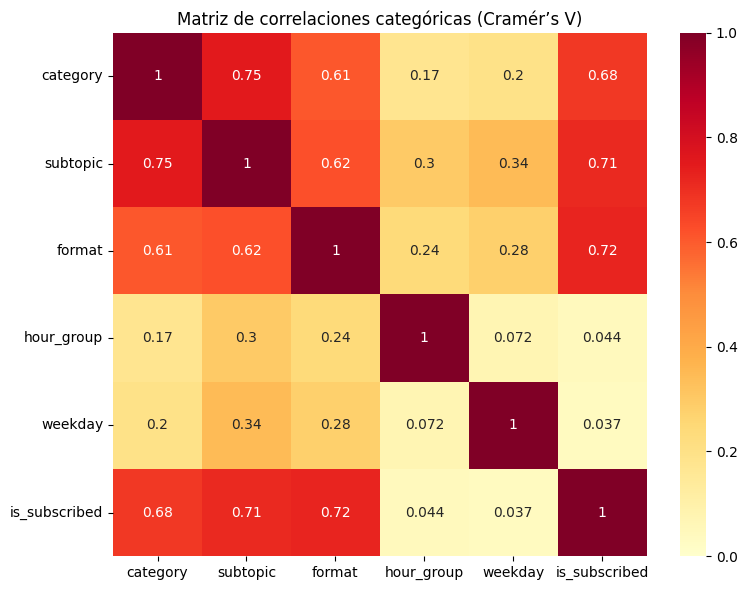

In [ ]:
# Función para calcular Cramér’s V
def cramers_v(x, y):
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Seleccionar variables categóricas relevantes
cat_vars = ["category", "subtopic", "format", "hour_group", "weekday", "is_subscribed"]

# Calcular matriz de Cramér’s V
matrix = pd.DataFrame(index=cat_vars, columns=cat_vars, dtype=float)
for var1 in cat_vars:
    for var2 in cat_vars:
        try:
            matrix.loc[var1, var2] = cramers_v(df_embed[var1].astype(str), df_embed[var2].astype(str))
        except Exception:
            matrix.loc[var1, var2] = np.nan

# ============================================================
# Visualización del heatmap
# ============================================================
plt.figure(figsize=(8,6))
sns.heatmap(matrix.astype(float), annot=True, cmap="YlOrRd", vmin=0, vmax=1)
plt.title("Matriz de correlaciones categóricas (Cramér’s V)")
plt.tight_layout()
plt.show()

#### 6.6 Identificación de segmentos

Se hará mediante exploración del espacio de embeddings

Con esta sección busco darme una idea de los grupos, como mi espacio es bastante grande, usaré una muestra de 3000 ejemplos para tratar de entender exploratoriamente como se comportan mis datos.

* Se toma una muestra de 3000 ejemplos
* Se aplica t-sne
* Se aplica PCA

In [ ]:
# ------------------------------------------------------------
# Muestra y normalización
# ------------------------------------------------------------
max_points = 3000  # ajusta si tu dataset es grande
df_tsne = df_embed.sample(min(len(df_embed), max_points), random_state=42).reset_index(drop=True)
X = normalize(np.vstack(df_tsne["content_vec"].values))

# ------------------------------------------------------------
# t-SNE
# ------------------------------------------------------------
print(f"Ejecutando t-SNE sobre {X.shape[0]} puntos...")
tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate="auto",
    init="random",
    random_state=42
)
tsne_result = tsne.fit_transform(X)
df_tsne["tsne_1"] = tsne_result[:, 0]
df_tsne["tsne_2"] = tsne_result[:, 1]
print("t-SNE completado")

# ------------------------------------------------------------
# Visualización t-SNE
# ------------------------------------------------------------
fig = px.scatter(
    df_tsne,
    x="tsne_1",
    y="tsne_2",
    opacity=0.6,
    title="Espacio t-SNE de los embeddings de contenido",
    hover_data=["video_title", "category", "channel_title"]
)
fig.update_traces(marker=dict(size=5, color="steelblue", opacity=0.7, line=dict(width=0)))
fig.update_layout(
    template="plotly_white",
    width=900,
    height=650,
    showlegend=False
)
fig.show()

# ------------------------------------------------------------
# PCA
# ------------------------------------------------------------
print("Ejecutando PCA")
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X)
df_tsne["pca_1"] = pca_result[:, 0]
df_tsne["pca_2"] = pca_result[:, 1]

fig = px.scatter(
    df_tsne,
    x="pca_1",
    y="pca_2",
    opacity=0.6,
    title="PCA de los embeddings de contenido",
    hover_data=["video_title", "category", "channel_title"]
)
fig.update_traces(marker=dict(size=5, color="darkorange", opacity=0.7, line=dict(width=0)))
fig.update_layout(
    template="plotly_white",
    width=900,
    height=650,
    showlegend=False
)
fig.show()

Ejecutando t-SNE sobre 3000 puntos...
t-SNE completado


Ejecutando PCA (más rápido pero lineal)...


Calculando inercia para PCA...


100%|██████████| 13/13 [00:00<00:00, 19.53it/s]



Calculando inercia para t-SNE...


100%|██████████| 13/13 [00:00<00:00, 14.59it/s]


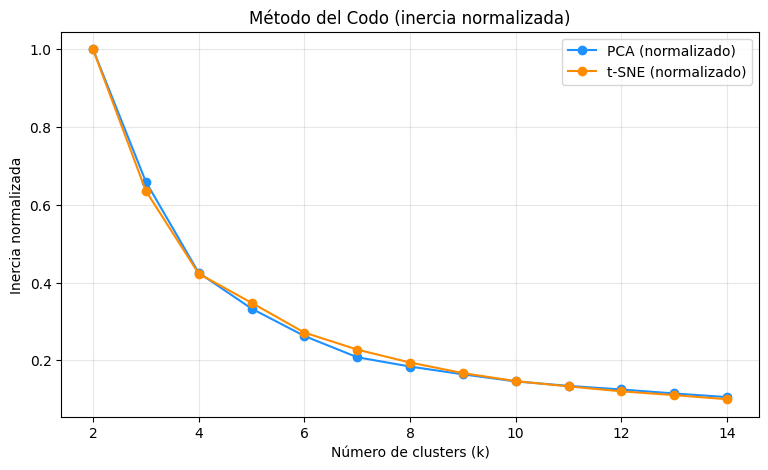

In [ ]:
# ============================================================
# Método del Codo (Elbow Method) — PCA vs t-SNE
# ============================================================

K_range = range(2, 15)
inertia_pca, inertia_tsne = [], []

X_pca = df_tsne[["pca_1", "pca_2"]].values
X_tsne = df_tsne[["tsne_1", "tsne_2"]].values

# ------------------------------------------------------------
# Calcular inercia para cada K
# ------------------------------------------------------------
print("Calculando inercia para PCA...")
for k in tqdm(K_range):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_pca)
    inertia_pca.append(km.inertia_)

print("\nCalculando inercia para t-SNE...")
for k in tqdm(K_range):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_tsne)
    inertia_tsne.append(km.inertia_)

# ------------------------------------------------------------
# Graficar el método del codo
# ------------------------------------------------------------
plt.figure(figsize=(9,5))
plt.plot(K_range, np.array(inertia_pca)/max(inertia_pca), "o-", label="PCA (normalizado)", color="dodgerblue")
plt.plot(K_range, np.array(inertia_tsne)/max(inertia_tsne), "o-", label="t-SNE (normalizado)", color="darkorange")
plt.title("Método del Codo (inercia normalizada)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia normalizada")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Silhouette promedio (PCA): 0.440
Silhouette promedio (t-SNE): 0.447


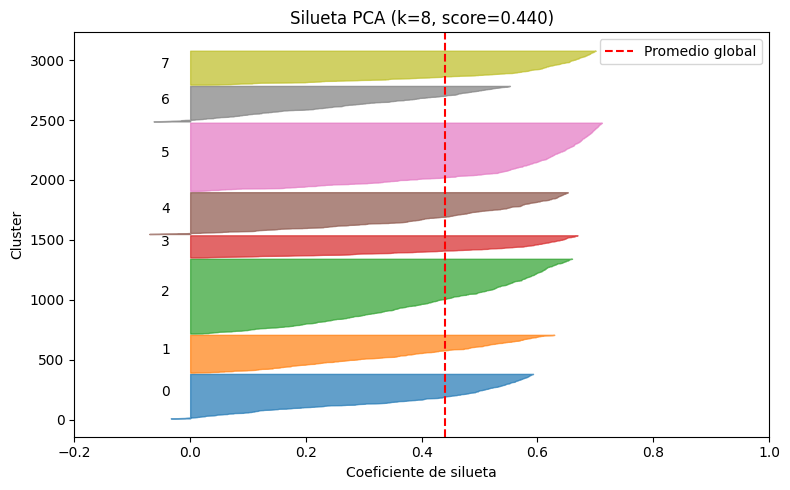

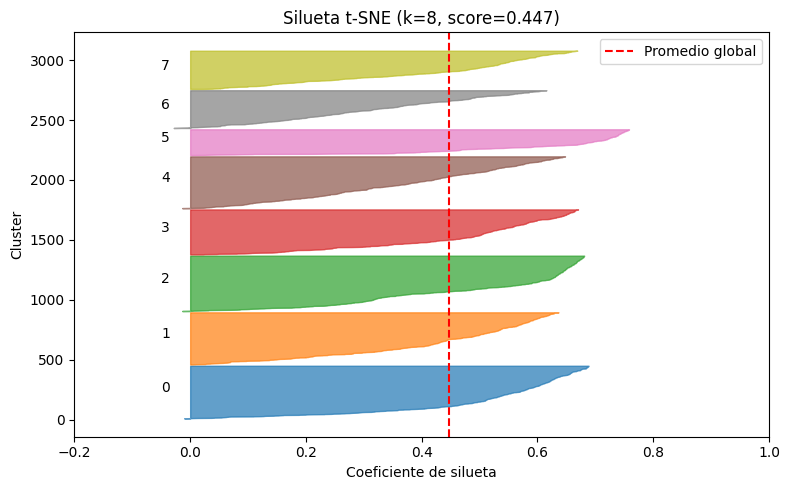

In [ ]:
# ============================================================
# Evaluación de cohesión: Gráfico de Silueta (PCA y t-SNE)
# ============================================================

# ------------------------------------------------------------
# K-Means sobre PCA
# ------------------------------------------------------------
X_pca = df_tsne[["pca_1", "pca_2"]].values
k_pca = 8  # ajusta según tu número de temas o clusters esperados
kmeans_pca = KMeans(n_clusters=k_pca, random_state=42, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)

silhouette_avg_pca = silhouette_score(X_pca, labels_pca)
print(f"Silhouette promedio (PCA): {silhouette_avg_pca:.3f}")

# ------------------------------------------------------------
# K-Means sobre t-SNE
# ------------------------------------------------------------
X_tsne = df_tsne[["tsne_1", "tsne_2"]].values
k_tsne = 8
kmeans_tsne = KMeans(n_clusters=k_tsne, random_state=42, n_init=10)
labels_tsne = kmeans_tsne.fit_predict(X_tsne)

silhouette_avg_tsne = silhouette_score(X_tsne, labels_tsne)
print(f"Silhouette promedio (t-SNE): {silhouette_avg_tsne:.3f}")

# ------------------------------------------------------------
# Función auxiliar para plotear silueta
# ------------------------------------------------------------
def plot_silhouette(X, labels, title):
    n_clusters = len(np.unique(labels))
    silhouette_vals = silhouette_samples(X, labels)
    y_lower = 10
    fig, ax = plt.subplots(figsize=(8,5))

    for i in range(n_clusters):
        cluster_vals = silhouette_vals[labels == i]
        cluster_vals.sort()
        size_cluster_i = cluster_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        color = plt.cm.tab10(i / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_vals, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # espacio entre clusters

    ax.axvline(np.mean(silhouette_vals), color="red", linestyle="--", label="Promedio global")
    ax.set_title(title)
    ax.set_xlabel("Coeficiente de silueta")
    ax.set_ylabel("Cluster")
    ax.legend()
    ax.set_xlim([-0.2, 1])
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# Visualizar siluetas para PCA y t-SNE
# ------------------------------------------------------------
plot_silhouette(X_pca, labels_pca, f"Silueta PCA (k={k_pca}, score={silhouette_avg_pca:.3f})")
plot_silhouette(X_tsne, labels_tsne, f"Silueta t-SNE (k={k_tsne}, score={silhouette_avg_tsne:.3f})")

In [ ]:
# ============================================================
# Visualización enriquecida de clusters en PCA y t-SNE
# ============================================================

# Unimos la info original (video, categoría, subtopic) con los embeddings
df_pca_vis = pd.DataFrame(X_pca, columns=["pca_1", "pca_2"])
df_pca_vis["cluster"] = labels_pca
df_pca_vis[["video_title", "category", "subtopic"]] = df_embed[["video_title", "category", "subtopic"]].iloc[:len(df_pca_vis)].values

df_tsne_vis = pd.DataFrame(X_tsne, columns=["tsne_1", "tsne_2"])
df_tsne_vis["cluster"] = labels_tsne
df_tsne_vis[["video_title", "category", "subtopic"]] = df_embed[["video_title", "category", "subtopic"]].iloc[:len(df_tsne_vis)].values

# ------------------------------------------------------------
# PCA
# ------------------------------------------------------------
fig_pca = px.scatter(
    df_pca_vis,
    x="pca_1", y="pca_2",
    color="cluster",
    hover_data={
        "video_title": True,
        "category": True,
        "subtopic": True,
        "cluster": True,
        "pca_1": False, "pca_2": False
    },
    title=f"Distribución de clusters en espacio PCA (k={k_pca}, silhouette={silhouette_avg_pca:.3f})",
    color_continuous_scale="Turbo"
)
fig_pca.update_traces(
    marker=dict(size=6, opacity=0.8, line=dict(width=0.3, color="white")),
    hovertemplate="<b>%{customdata[0]}</b><br>Categoría: %{customdata[1]}<br>Subtema: %{customdata[2]}<br>Cluster: %{customdata[3]}"
)
fig_pca.update_layout(template="plotly_white", width=900, height=600)
fig_pca.show()

# ------------------------------------------------------------
# t-SNE
# ------------------------------------------------------------
fig_tsne = px.scatter(
    df_tsne_vis,
    x="tsne_1", y="tsne_2",
    color="cluster",
    hover_data={
        "video_title": True,
        "category": True,
        "subtopic": True,
        "cluster": True,
        "tsne_1": False, "tsne_2": False
    },
    title=f"Distribución de clusters en espacio t-SNE (k={k_tsne}, silhouette={silhouette_avg_tsne:.3f})",
    color_continuous_scale="Turbo"
)
fig_tsne.update_traces(
    marker=dict(size=6, opacity=0.8, line=dict(width=0.3, color="white")),
    hovertemplate="<b>%{customdata[0]}</b><br>Categoría: %{customdata[1]}<br>Subtema: %{customdata[2]}<br>Cluster: %{customdata[3]}"
)
fig_tsne.update_layout(template="plotly_white", width=900, height=600)
fig_tsne.show()


In [ ]:
# ============================================================
# Heatmap: proporción de categorías por cluster
# ============================================================

def top3_categories_per_cluster(df, label_col="cluster", cat_col="category"):
    """Devuelve el top 3 de categorías más frecuentes por cluster."""
    summary = (
        df.groupby(label_col)[cat_col]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )
    # Top 3 por cluster
    top3 = summary.groupby(label_col).head(3).reset_index(drop=True)
    return top3

# --- PCA ---
df_pca_vis["category"] = df_embed["category"].iloc[:len(df_pca_vis)].values
top3_pca = top3_categories_per_cluster(df_pca_vis)

# --- t-SNE ---
df_tsne_vis["category"] = df_embed["category"].iloc[:len(df_tsne_vis)].values
top3_tsne = top3_categories_per_cluster(df_tsne_vis)


def plot_heatmap(df, title):
    # Crear tabla pivote (categoría vs cluster)
    pivot = (
        df.pivot(index="category", columns="cluster", values="proportion")
        .fillna(0)
    )

    # Ordenar columnas (clusters)
    pivot = pivot.reindex(sorted(pivot.columns), axis=1)

    # Crear heatmap interactivo
    fig = px.imshow(
        pivot,
        color_continuous_scale="Turbo",
        title=title,
        labels=dict(x="Cluster", y="Categoría", color="Proporción"),
        aspect="auto"
    )
    fig.update_layout(
        width=950, height=600, template="plotly_white",
        xaxis_title="Cluster", yaxis_title="Categoría"
    )
    fig.show()

# Visualizar nuevamente
plot_heatmap(top3_pca, "PCA — Top 3 categorías más representadas por cluster")
plot_heatmap(top3_tsne, "t-SNE — Top 3 categorías más representadas por cluster")


#### 6.7 Detección de Outliers

El Z-score mide cuántas desviaciones estándar está un valor respecto a la media:

Por qué se usa |z| > 3: Es un criterio clásico en estadística para detectar valores atípicos “muy extremos”.

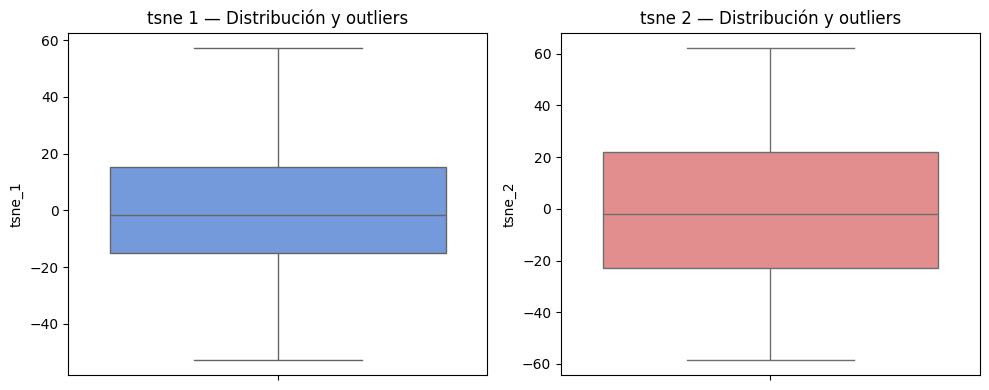

Detectados 0 outliers en el espacio PCA (0.00% del total)


Empty DataFrame
Columns: [video_title, category, tsne_1, tsne_2]
Index: []

In [ ]:
# ============================================================
# Outliers en el espacio T-SNE con Z-score
# ============================================================

# Boxplots de componentes principales
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(y=df_tsne["tsne_1"], color="cornflowerblue", ax=axes[0])
sns.boxplot(y=df_tsne["tsne_2"], color="lightcoral", ax=axes[1])
axes[0].set_title("tsne 1 — Distribución y outliers")
axes[1].set_title("tsne 2 — Distribución y outliers")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Cálculo de Z-scores para identificar outliers
# ------------------------------------------------------------
df_tsne["z_tsne1"] = zscore(df_tsne["tsne_1"])
df_tsne["z_tsne2"] = zscore(df_tsne["tsne_2"])

# Definir umbral (|z| > 3 es común)
threshold = 3
outliers = df_tsne[(abs(df_tsne["z_tsne1"]) > threshold) | (abs(df_tsne["z_tsne2"]) > threshold)]
print(f"Detectados {len(outliers)} outliers en el espacio PCA ({len(outliers)/len(df_tsne)*100:.2f}% del total)")

# Mostrar ejemplos
display(outliers[["video_title", "category", "tsne_1", "tsne_2"]].head(10))

Pra que no existen patrones de anomlías importantes que se puedan detectar con un método clásico como Z-Score. Vamos a probar con Isolation forest, un método de ML más robusto:


    El Isolation Forest  es un modelo basado en árboles de decisión diseñado para detectar anomalías.
    A diferencia de otros métodos (como el z-score o el clustering), no modela la densidad de los datos ni la distancia entre puntos.
    Su idea clave es:

        “Las anomalías son más fáciles de aislar que los puntos normales.”

In [ ]:
# ============================================================
# Detección de outliers con Isolation Forest sobre t-SNE
# ============================================================
# Prepara los datos del t-SNE
X_tsne = df_tsne[["tsne_1", "tsne_2"]].values

# Entrenamiento del Isolation Forest
iso = IsolationForest(
    contamination=0.03,  # proporción esperada de outliers (3%)
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
df_tsne["iforest_score"] = iso.fit_predict(X_tsne)
df_tsne["anomaly_score"] = iso.decision_function(X_tsne)

# Filtrar outliers detectados (-1 = outlier)
outliers_if = df_tsne[df_tsne["iforest_score"] == -1]
print(f"Outliers detectados por Isolation Forest: {len(outliers_if)} / {len(df_tsne)} ({len(outliers_if)/len(df_tsne)*100:.2f}%)")

# ============================================================
# 🔹 Visualización de outliers en el plano t-SNE
# ============================================================
fig = px.scatter(
    df_tsne,
    x="tsne_1",
    y="tsne_2",
    color="anomaly_score",
    color_continuous_scale="Inferno",
    title="Detección de Outliers con Isolation Forest (espacio t-SNE)",
    hover_data=["video_title", "category"],
    opacity=0.7
)

# Agregar los puntos marcados como anomalías
fig.add_scatter(
    x=outliers_if["tsne_1"],
    y=outliers_if["tsne_2"],
    mode="markers",
    marker=dict(size=8, color="cyan", symbol="x", line=dict(width=1, color="black")),
    name="Outliers detectados"
)

fig.update_layout(
    template="plotly_white",
    width=950,
    height=650,
    showlegend=True
)
fig.show()

Outliers detectados por Isolation Forest: 90 / 3000 (3.00%)


In [ ]:
# ============================================================
# Isolation Forest local (por cluster) — PCA y t-SNE
# ============================================================

# --- Aseguramos que df_pca_vis y df_tsne_vis tienen las columnas necesarias ---
for df_vis in [df_pca_vis, df_tsne_vis]:
    if "channel_title" not in df_vis.columns and "channel_title" in df_embed.columns:
        df_vis["channel_title"] = df_embed["channel_title"].iloc[:len(df_vis)].values

# --- Función para aplicar Isolation Forest por cluster ---
def isolation_per_cluster(df, coord_cols, cluster_col="cluster", contamination=0.05):
    df_out = df.copy()
    df_out["iforest_local"] = 1
    df_out["iforest_score"] = np.nan

    for c in sorted(df_out[cluster_col].unique()):
        subset = df_out[df_out[cluster_col] == c]
        if len(subset) < 10:
            continue
        X = subset[coord_cols].values
        iso = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=200,
            n_jobs=-1
        )
        scores = iso.fit_predict(X)
        decision = iso.decision_function(X)
        df_out.loc[subset.index, "iforest_local"] = scores
        df_out.loc[subset.index, "iforest_score"] = decision
    return df_out


# ============================================================
# PCA
# ============================================================
df_pca_iso = isolation_per_cluster(df_pca_vis, ["pca_1", "pca_2"], "cluster", contamination=0.05)
outliers_pca = df_pca_iso[df_pca_iso["iforest_local"] == -1]

fig_pca = px.scatter(
    df_pca_iso,
    x="pca_1", y="pca_2",
    color="cluster",
    opacity=0.55,
    title="Outliers locales (Isolation Forest por cluster — PCA)",
    hover_data={
        "video_title": True,
        "category": True,
        "subtopic": True,
        "channel_title": True,
        "cluster": True,
        "iforest_score": True
    },
    color_continuous_scale="Turbo"
)

# Outliers rojos con hover detallado
fig_pca.add_scatter(
    x=outliers_pca["pca_1"],
    y=outliers_pca["pca_2"],
    mode="markers",
    marker=dict(size=9, color="red", symbol="x", line=dict(width=1, color="black")),
    name="Outliers locales",
    text=outliers_pca.apply(lambda r: f"<b>{r['video_title']}</b><br>"
                                      f"Categoría: {r['category']}<br>"
                                      f"Subtema: {r['subtopic']}<br>"
                                      f"Canal: {r['channel_title']}<br>"
                                      f"Cluster: {r['cluster']}<br>"
                                      f"Score: {r['iforest_score']:.3f}", axis=1),
    hoverinfo="text"
)
fig_pca.update_layout(template="plotly_white", width=950, height=650)
fig_pca.show()


# ============================================================
# t-SNE
# ============================================================
df_tsne_iso = isolation_per_cluster(df_tsne_vis, ["tsne_1", "tsne_2"], "cluster", contamination=0.05)
outliers_tsne = df_tsne_iso[df_tsne_iso["iforest_local"] == -1]

fig_tsne = px.scatter(
    df_tsne_iso,
    x="tsne_1", y="tsne_2",
    color="cluster",
    opacity=0.55,
    title="Outliers locales (Isolation Forest por cluster — t-SNE)",
    hover_data={
        "video_title": True,
        "category": True,
        "subtopic": True,
        "channel_title": True,
        "cluster": True,
        "iforest_score": True
    },
    color_continuous_scale="Turbo"
)

fig_tsne.add_scatter(
    x=outliers_tsne["tsne_1"],
    y=outliers_tsne["tsne_2"],
    mode="markers",
    marker=dict(size=9, color="red", symbol="x", line=dict(width=1, color="black")),
    name="Outliers locales",
    text=outliers_tsne.apply(lambda r: f"<b>{r['video_title']}</b><br>"
                                      f"Categoría: {r['category']}<br>"
                                      f"Subtema: {r['subtopic']}<br>"
                                      f"Canal: {r['channel_title']}<br>"
                                      f"Cluster: {r['cluster']}<br>"
                                      f"Score: {r['iforest_score']:.3f}", axis=1),
    hoverinfo="text"
)
fig_tsne.update_layout(template="plotly_white", width=950, height=650)
fig_tsne.show()


# ============================================================
# Comparativa de porcentaje de outliers
# ============================================================
summary = pd.DataFrame({
    "Cluster": sorted(df_tsne_iso["cluster"].unique()),
    "Outliers_tSNE(%)": [
        (df_tsne_iso.query("cluster==@c")["iforest_local"] == -1).mean() * 100
        for c in sorted(df_tsne_iso["cluster"].unique())
    ],
    "Outliers_PCA(%)": [
        (df_pca_iso.query("cluster==@c")["iforest_local"] == -1).mean() * 100
        for c in sorted(df_pca_iso["cluster"].unique())
    ]
})

print("Porcentaje de outliers detectados por cluster:")
display(summary)

print(f"t-SNE promedio: {summary['Outliers_tSNE(%)'].mean():.2f}%")
print(f"PCA promedio: {summary['Outliers_PCA(%)'].mean():.2f}%")

Porcentaje de outliers detectados por cluster:


Cluster  Outliers_tSNE(%)  Outliers_PCA(%)
0        0          5.000000         5.107527
1        1          5.045872         5.063291
2        2          5.183585         5.120000
3        3          5.053191         5.376344
4        4          5.080831         5.142857
5        5          5.092593         5.087719
6        6          5.063291         5.050505
7        7          5.000000         5.281690

t-SNE promedio: 5.06%
PCA promedio: 5.15%



## 7. Partición temporal y definición de tareas
* Split de datset en train y test
* Definición de metricas a evaluar

#### 7.1 Spli de dataset

Se utilizará el tiempo como medida temporal, en un 80% para entreno y 20% para evaluar

In [ ]:
# Asegurar que timestamp es datetime
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

# Verifica que la conversión haya funcionado
print(df_embed["timestamp"].dtypes)
print(df_embed["timestamp"].head())

# Split temporal: por ejemplo, último 20% del tiempo como test
cut_ts = df_embed['timestamp'].quantile(0.8)
train = df_embed[df_embed['timestamp'] <= cut_ts].copy()
test  = df_embed[df_embed['timestamp'] >  cut_ts].copy()

print("train:", train['timestamp'].min(), "->", train['timestamp'].max(), "n=", len(train))
print("test :", test['timestamp'].min(),  "->", test['timestamp'].max(),  "n=", len(test))

datetime64[ns, UTC]
0   2018-02-22 02:05:35.427000+00:00
1   2018-02-22 03:49:54.096000+00:00
2   2018-02-22 05:27:06.367000+00:00
3   2018-02-22 06:26:38.438000+00:00
4   2018-02-22 14:20:32.963000+00:00
Name: timestamp, dtype: datetime64[ns, UTC]
train: 2018-02-22 02:05:35.427000+00:00 -> 2022-03-10 13:39:19.200000+00:00 n= 24949
test : 2022-03-10 13:40:19.690000+00:00 -> 2025-10-18 01:02:57.606000+00:00 n= 6238


#### 7.2 Definició  de métricas para modelos

Este apartado describe las métricas utilizadas para evaluar los tres recomendadores desarrollados (Popularidad, Contenido y Híbrido). Incluye su interpretación conceptual y sus fórmulas en notación matemática LaTeX.

---

##### **Precision@K**
**Qué mide:** Exactitud de las recomendaciones: qué proporción de los videos recomendados son realmente relevantes (vistos posteriormente por el usuario).

$$
\text{Precision@K} = \frac{|R \cap T|}{K}
$$

Donde:
- $R$ = conjunto de videos recomendados (Top-K)
- $T$ = conjunto de videos realmente vistos (True Set)
- $K$ = número de videos recomendados

**Interpretación:**
- Valores cercanos a 1 indican recomendaciones más precisas.
- Ejemplo: $\text{Precision@10} = 0.1$ → 1 de cada 10 videos recomendados fue efectivamente visto.

---

##### **Recall@K**
**Qué mide:** Qué fracción de los videos realmente vistos fueron recuperados por el sistema dentro de las recomendaciones.

$$
\text{Recall@K} = \frac{|R \cap T|}{|T|}
$$

**Interpretación:**
- Evalúa la **capacidad de recuperación** del modelo.
- Un valor alto significa que el sistema logra capturar la mayoría de los intereses reales del usuario.

---

##### **Coverage**
**Qué mide:** Porcentaje del catálogo total de videos que aparece al menos una vez en las listas de recomendación.

$$
\text{Coverage} = \frac{|R_{unique}|}{|I_{total}|}
$$

Donde:
- $R_{unique}$ = videos únicos recomendados por el modelo
- $I_{total}$ = tamaño total del catálogo (número de videos en *train*)

**Interpretación:**
- Cuanto mayor sea el Coverage, mayor es la **variedad global** de recomendaciones.
- Un Coverage bajo indica que el sistema repite siempre los mismos videos populares.

---

##### **Diversity**
**Qué mide:** La diversidad semántica dentro de una lista de recomendaciones. Se basa en la similitud del coseno entre los embeddings de contenido de los videos.

$$
\text{Diversity} = 1 - \frac{1}{N} \sum_{i<j} \text{sim}_{\text{coseno}}(v_i, v_j)
$$

Donde:
- $v_i, v_j$ son los vectores de contenido de los videos $i$ y $j$.
- $\text{sim}_{\text{coseno}}$ mide la similitud entre embeddings.

**Interpretación:**
- Valores altos → recomendaciones variadas entre sí.
- Valores bajos → recomendaciones muy parecidas (monotemáticas).

---

##### **ClusterDiversity**
**Qué mide:** Diversidad temática de las recomendaciones, es decir, cuántos *clusters* distintos aparecen dentro de una lista recomendada.

$$
\text{ClusterDiversity} = \frac{1}{M} \sum_{i=1}^{M} \frac{|C_i^{unique}|}{|C_i|}
$$

Donde:
- $M$ = número total de listas (ej. número de videos en test)
- $C_i$ = conjunto de clusters de los videos recomendados para el video $i$

**Interpretación:**
- Evalúa la **diversidad de temas** presentes en las recomendaciones.
- Valor alto = lista con varios temas; valor bajo = lista concentrada en un solo tema.

---

##### **BubbleIndex**
**Qué mide:** Grado de concentración de las recomendaciones en el mismo *cluster temático* que el video de origen. Refleja el nivel de "burbuja algorítmica".

$$
\text{BubbleIndex}(v) = \frac{1}{K} \sum_{i=1}^{K} \mathbb{1}_{[c_i = c_0]}
$$

Donde:
- $c_0$ = cluster del video de referencia (video base)
- $c_i$ = cluster del video recomendado $i$
- $\mathbb{1}_{[\text{condición}]}$ = 1 si la condición se cumple, 0 en caso contrario

**Interpretación:**
- Valores cercanos a 1 → recomendaciones muy concentradas (burbuja fuerte).
- Valores cercanos a 0 → recomendaciones más diversas entre temas.

---

##### **Resumen comparativo de métricas**

| Métrica | Tipo | Qué mide | Ideal |
|----------|------|-----------|--------|
| Precision@K | Relevancia | Exactitud local de recomendaciones | Alto |
| Recall@K | Relevancia | Capacidad de recuperar lo visto | Alto |
| Coverage | Variedad global | Porcentaje del catálogo cubierto | Alto |
| Diversity | Variedad local | Diferencia semántica dentro de lista | Alto |
| ClusterDiversity | Variedad temática | Diferencia entre clusters recomendados | Alto |
| BubbleIndex | Sesgo temático | Grado de burbuja algorítmica | Bajo |

---

##### **Configuración temporal utilizada**
Las métricas de precisión y recall se calculan considerando una ventana temporal de **24 horas** después de la visualización original:

$$
\text{window_hours} = 24
$$

Esto significa que un video recomendado se considera relevante si el usuario lo vio dentro de las siguientes 24 horas después del video de referencia.

In [177]:
# ============================================================
# Ground truth temporal
# ============================================================
def get_true_set_by_time(vid, test, train, window_hours=24):
    """
    Obtiene los videos realmente vistos después de un video base, dentro de una ventana temporal.
    Sirve como “ground truth” temporal para evaluar si las recomendaciones anticipan el comportamiento del usuario.
    """
    row = test.loc[test["video_id"] == vid].iloc[0]
    t0 = row["timestamp"]
    mask = (
        (test["timestamp"] > t0) &
        (test["timestamp"] <= t0 + pd.Timedelta(hours=window_hours))
    )
    true_set = set(test.loc[mask, "video_id"]) - {vid}
    return true_set


# ============================================================
# Métricas de evaluación
# ============================================================
def precision_at_k(recommended, true_set):
    if len(recommended) == 0: return 0.0
    hit = sum(1 for x in recommended if x in true_set)
    return hit / len(recommended)

def recall_at_k(recommended, true_set):
    if len(true_set) == 0: return 0.0
    hit = sum(1 for x in recommended if x in true_set)
    return hit / len(true_set)

def coverage(rec_lists, all_items):
    recs = set(x for sub in rec_lists for x in sub)
    return len(recs) / len(all_items)

def diversity(rec_lists, df, emb_col="content_vec"):
    vals = []
    for rec in rec_lists:
        if len(rec) < 2: continue
        vecs = np.vstack([
            df.loc[df["video_id"] == v, emb_col].values[0]
            for v in rec if v in df["video_id"].values
        ])
        sim = cosine_similarity(vecs)
        vals.append(1 - np.mean(sim[np.triu_indices_from(sim, 1)]))
    return np.mean(vals) if vals else 0.0

# ============================================================
# Métricas temáticas
# ============================================================
def diversity_clusters(rec_lists, df, cluster_col="cluster"):
    vals = []
    for rec in rec_lists:
        clusters = df.loc[df["video_id"].isin(rec), cluster_col].dropna().values
        if len(clusters) > 1:
            vals.append(len(np.unique(clusters)) / len(clusters))
    return np.mean(vals) if vals else 0.0

def bubble_index(video_id, recs, df, cluster_col="cluster"):
    if cluster_col not in df.columns: return np.nan
    if video_id not in df["video_id"].values: return np.nan
    c0 = df.loc[df["video_id"] == video_id, cluster_col].values[0]
    rec_clusters = df.loc[df["video_id"].isin(recs), cluster_col].dropna().values
    if len(rec_clusters) == 0:
        return np.nan
    return np.mean(rec_clusters == c0)

## 8. Modelado

A continuación se explica, cómo funcionan las tres funciones de recomendación mostradas en el código: **popularidad**, **basado en contenido** y **híbrido**.

- **Popularidad**: baseline, cero personalización. Útil para cobertura y arranque.
- **Contenido**: personaliza por *tema/semántica*, ignora tiempo/canales.
- **Híbrido**: combinación ponderada de semántica + contexto + afinidad (suscripción/categorías), suele rendir mejor en *precision@K* cuando el contexto importa.



### 8.1 Contexto mínimo (variables y datos)


- `train`: subconjunto de entrenamiento con columnas como `video_id`, `content_vec` (embeddings del contenido), `hour`, `weekday`, `channel_title`, `category`, `subtopic`, `format`, `is_subscribed`.
- `test`: subconjunto de prueba que contiene, al menos, `video_id` y `content_vec` (para encontrar vecinos similares).
- `K` (por defecto `10`): número de recomendaciones a devolver.
- Utilidades:
  - `normalize`: normalización L2 (longitud unitaria) de vectores.
  - `cosine_similarity`: similitud coseno entre vectores/matrices.

> Nota: El código asume que `content_vec` es un vector NumPy (p.ej., de 300 dimensiones). Si no lo es, lo convierte/normaliza; y si algún vector en `train` no es `ndarray`, lo reemplaza por un vector **cero** del mismo tamaño para mantener la dimensionalidad.

---

### 8.2  Recomendador por **Popularidad**

**Función**: `recommend_popularity(video_id=None, k=K)`

#### Qué hace
Ignora el `video_id` de entrada y **siempre** devuelve los `k` videos más vistos en el conjunto `train`.

#### Cómo funciona
1. **Precómputo**: `top_items = train["video_id"].value_counts().head(100).index.tolist()`
   - Cuenta ocurrencias de cada `video_id` en `train`
   - Se queda con el top-100 y lo guarda en una lista.
2. **Recomendación**: devuelve `top_items[:k]`.

#### Ventajas
- **Simplicidad** y robustez ante frío de ítem/usuario (no depende del `video_id` de consulta).
- Sirve como **baseline** razonable.

#### Limitaciones
- No personaliza: sugiere lo mismo a todos.
- Puede reforzar sesgos hacia creadores o temas dominantes

In [174]:
# --- Popularidad ---
top_items = train["video_id"].value_counts().head(100).index.tolist()
def recommend_popularity(video_id=None, k=K):
    """Siempre recomienda los más populares del train."""
    k = int(k)
    return top_items[:k]

### 8.3 Recomendador **Basado en Contenido**


**Función**: `recommend_content_based(video_id, train=train, test=test, k=K)`

#### Qué hace
Dado un `video_id` de `test`, encuentra en `train` los videos **más similares** en términos del vector de contenido (`content_vec`) y devuelve los `k` más parecidos, **excluyendo** recomendar el mismo `video_id`.

#### Pasos internos
1. **Chequeo de existencia**: si `video_id` no está en `test["video_id"]`, retorna `[]` (no válido).
2. **Vector objetivo**: extrae `target_vec = test.loc[test["video_id"]==video_id, "content_vec"].values[0]`.
   - Lo asegura como `np.ndarray` y lo **normaliza L2**: `target_vec = normalize(target_vec.reshape(1, -1))`.
3. **Matriz de contenido del train**:
   - Construye `mat = np.vstack([...])` con los `content_vec` de `train`.
   - Si algún vector no es `ndarray`, lo sustituye por `np.zeros(300)` (mantener dimensión).
   - **Normaliza L2** toda la matriz: `mat = normalize(mat)`.
4. **Similitudes coseno**: `sims = cosine_similarity(target_vec, mat).ravel()`.
5. **Evitar auto-recomendación**: si `train["video_id"] == video_id`, fuerza su similitud a `-1.0`.
6. **Top-K**: ordena de mayor a menor y toma índices `top_idx = np.argsort(sims)[::-1][:k]`.
7. **Salida**: `train.iloc[top_idx]["video_id"].tolist()`.

#### Intuición
- La **similitud coseno** prioriza la dirección del embedding, capturando parecido semántico (título, descripción, transcript, etc.).
- La **normalización L2** evita que la magnitud del vector domine la similitud.

#### Ventajas
- Recomendaciones **relevantes por tema/semántica**.
- No requiere datos de interacción del usuario (solo del contenido).

#### Limitaciones y cuidados
- Si hay `content_vec` faltantes o ruidosos, la calidad baja (los ceros actúan como “neutros”).
- No incorpora señales temporales/horarias ni afinidad personal (suscripción, histórico individual).

In [175]:
# --- Contenido ---
def recommend_content_based(video_id, train=train, test=test, k=K):
    if video_id not in test["video_id"].values:
        return []
    target_vec = test.loc[test["video_id"] == video_id, "content_vec"].values[0]
    if not isinstance(target_vec, np.ndarray):
        target_vec = np.array(target_vec, dtype=float)
    target_vec = normalize(target_vec.reshape(1, -1))
    mat = np.vstack([
        x if isinstance(x, np.ndarray) else np.zeros(300)
        for x in train["content_vec"].values
    ])
    mat = normalize(mat)
    sims = cosine_similarity(target_vec, mat).ravel()
    mask_same = (train["video_id"].values == video_id)
    sims = np.where(mask_same, -1.0, sims)
    top_idx = np.argsort(sims)[::-1][:k]
    return train.iloc[top_idx]["video_id"].tolist()


### 8.4 Recomendador **Híbrido** (Contenido + Contexto/Categorías)


**Función**: `recommend_hybrid(video_id, train=train, test=test, k=K, w=None)`

#### Qué hace
Combina la **similitud textual** (embeddings) con señales **contextuales y categóricas**: hora del día, día de semana, mismo canal, categoría, subtema, formato, y un **ajuste por suscripción**. Devuelve los `k` videos de `train` con mayor puntuación híbrida, excluyendo el mismo `video_id`.

#### Pasos internos
1. **Chequeo de existencia**: si el `video_id` no está en `test`, retorna `[]`.
2. **Fila objetivo**: `row = test.loc[test["video_id"]==video_id].iloc[0]`.
3. **Normalización de tiempo**:
   - `weekday` mapeado a entero `[0..6]` usando `mapping = {"Monday":0, …, "Sunday":6}` si viniera como string/categoría.
4. **Similitudes de cada componente**:
   - **Texto (embeddings)**: `q = row["content_vec"].reshape(1,-1)`; `mat = normalize(vstack(train["content_vec"]))`; `s_text = cosine_similarity(q, mat).ravel()`.
   - **Hora** (circularidad 24h) y **día** (circularidad 7d): se usa una **similitud circular**:
     
     $$\Delta = |a-b|; \quad \Delta = \min(\Delta, \text{period} - \Delta)$$
     $$s_\text{circ}(a,b) = \frac{1 + \cos\left(\pi \frac{\Delta}{\text{period}/2}\right)}{2}$$
     
     - Esto da 1 cuando la diferencia horaria/semana es 0, decae a 0 en media vuelta (12h o 3.5 días) y vuelve a 1 en una vuelta completa.
     - Implementado como `s_hour` y `s_week`.
   - **Categorías exactas** (indicadores binarios):
     - `s_channel = 1` si mismo `channel_title`, si no `0`.
     - `s_cat`, `s_sub`, `s_fmt` análogos para `category`, `subtopic`, `format`.
5. **Ponderación (pesos `w`)**:
   - Por defecto: `w = {text:0.55, hour:0.10, weekday:0.05, channel:0.10, category:0.08, subtopic:0.07, fmt:0.03, subscribed_boost:0.02, interact_boost:0.00}`.
   - Puntuación base (antes de boosts):
     
     $$
     s = w_{text}\, s_{text} + w_{hour}\, s_{hour} + w_{weekday}\, s_{week} + w_{channel}\, s_{channel} + w_{category}\, s_{cat} + w_{subtopic}\, s_{sub} + w_{fmt}\, s_{fmt}
     $$

6. **Ajuste por suscripción**:
   - Si `train["is_subscribed"]` es 1, multiplica: `s *= (1 + w["subscribed_boost"] * subscribed)`.
   - Aumenta ligeramente videos de **canales a los que estás suscrito**.
   - *Nota*: `interact_boost` aparece en los pesos, pero en la versión mostrada **no se usa** (posible campo futuro para likes, comentarios, etc.).
7. **Evitar auto-recomendación**: fuerza `-1.0` si `train["video_id"] == video_id`.
8. **Top-K**: ordena `s` y devuelve los `k` mayores `video_id`.

#### Intuición
- Mezcla **semejanza semántica** (contenido) con **contexto de consumo** (hora/día) y **afinidad explícita** (mismo canal/suscripción), mejorando la relevancia temporal y de preferencia.

#### Ventajas
- Más **personalizable** y sensible al **contexto** que el puro contenido.
- Control fino vía **pesos** `w` según métricas offline/online.

#### Limitaciones y cuidados
- Requiere datos limpios en columnas de contexto; si vienen como texto/categoría sin mapear, hay que convertirlos a numéricos (el código ya contempla mapeo de `weekday`).
- Una mala elección de **pesos** puede sesgar en exceso hacia ciertos canales/categorías.
- El boost de suscripción es **multiplicativo**; conviene validar su impacto con métricas.


In [176]:
# --- Híbrido ---
def recommend_hybrid(video_id, train=train, test=test, k=K, w=None):
    if video_id not in test["video_id"].values:
        return []

    row = test.loc[test["video_id"] == video_id].iloc[0]

    # Asegurar que weekday/hora sean numéricos (evita errores tipo 'Friday')
    mapping = {
        "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
        "Friday": 4, "Saturday": 5, "Sunday": 6
    }

    if isinstance(row["weekday"], str):
        row["weekday"] = mapping.get(row["weekday"], np.nan)

    if train["weekday"].dtype == object or str(train["weekday"].dtype).startswith("category"):
        train["weekday"] = train["weekday"].map(mapping)

    # Define similitud circular
    def circular_sim(a, b, period):
        a, b = float(a), b.astype(float)
        delta = np.abs(a - b)
        delta = np.minimum(delta, period - delta)
        return (1 + np.cos(np.pi * delta / (period / 2))) / 2

    # Pesos por defecto
    if w is None:
        w = dict(text=0.55, hour=0.10, weekday=0.05,
                 channel=0.10, category=0.08, subtopic=0.07,
                 fmt=0.03, subscribed_boost=0.02, interact_boost=0.00)

    # Similitudes
    q = row["content_vec"].reshape(1, -1)
    mat = np.vstack(train["content_vec"].values)
    mat = normalize(mat)

    s_text = cosine_similarity(q, mat).ravel()
    s_hour = circular_sim(row["hour"], train["hour"].values, 24)
    s_week = circular_sim(row["weekday"], train["weekday"].values, 7)
    s_channel = (train["channel_title"].values == row["channel_title"]).astype(float)
    s_cat     = (train["category"].values == row["category"]).astype(float)
    s_sub     = (train["subtopic"].values == row["subtopic"]).astype(float)
    s_fmt     = (train["format"].values == row["format"]).astype(float)

    # Ajustes por suscripción
    subscribed = train["is_subscribed"].fillna(0).values.astype(float)

    s = (w["text"]*s_text + w["hour"]*s_hour + w["weekday"]*s_week +
         w["channel"]*s_channel + w["category"]*s_cat +
         w["subtopic"]*s_sub + w["fmt"]*s_fmt)
    s *= (1 + w["subscribed_boost"] * subscribed)

    # Evitar recomendar el mismo video
    mask_same = (train["video_id"].values == video_id)
    sims = np.where(mask_same, -1.0, s)
    top_idx = np.argsort(sims)[::-1][:k]

    return train.iloc[top_idx]["video_id"].tolist()

### 8.6 T-SNE Y Kmeans
Dado que las métricas de evaluación que diseñé utilizan cluster temáticos, es necesario realizar y aplicar estos algoritmos de reducción como el TSNE y Kmeans sobre el conjunto de datos complet (Recordemos que en el EDA fue solo sobre unamuestra).


Esto permite entender qué tan variado o encerrado es el conjunto de recomendaciones.

Por eso el proyecto incluye métricas como:

* Diversity
* ClusterDiversity
* BubbleIndex

In [147]:
# ============================================================
# K-Means clustering temático con barra de progreso
# ============================================================
from tqdm.auto import tqdm
from time import sleep

print("\nEntrenando K-Means temático sobre embeddings t-SNE...")

sample_vecs = np.vstack(df_embed["content_vec"].values)

# --- t-SNE con barra de progreso simulada ---
# (t-SNE no expone callbacks, así que mostramos una barra de "espera")
n_steps = 20  # número de pasos visibles (ajustable)
with tqdm(total=n_steps, desc="Calculando t-SNE", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}") as pbar:
    tsne = TSNE(
        n_components=2,
        perplexity=40,
        random_state=42,
        init="random",
        learning_rate="auto"
    )
    # Ejecutar t-SNE mientras mostramos la barra
    for i in range(n_steps):
        sleep(0.05)  # simula progreso mientras se ajusta
        pbar.update(1)
    tsne_coords = tsne.fit_transform(normalize(sample_vecs))

df_embed["tsne_1"] = tsne_coords[:, 0]
df_embed["tsne_2"] = tsne_coords[:, 1]

# --- K-Means con progreso real ---
print("\nAplicando K-Means...")
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10, verbose=0)

# tqdm para mostrar progreso del fit_predict
with tqdm(total=len(df_embed), desc="Clustering K-Means", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}") as pbar:
    df_embed["cluster"] = kmeans.fit_predict(df_embed[["tsne_1", "tsne_2"]])
    pbar.update(len(df_embed))

# Propagar a train/test
train["cluster"] = df_embed.loc[train.index, "cluster"].values
test["cluster"]  = df_embed.loc[test.index, "cluster"].values

print("Clustering completado.")


Entrenando K-Means temático sobre embeddings t-SNE...


Calculando t-SNE:   0%|          | 0/20


Aplicando K-Means...


Clustering K-Means:   0%|          | 0/31217

✅ Clustering completado.


### 8.7 Evaluar y comparar modelos

In [169]:
# ============================================================
# Evaluación comparativa
# ============================================================
K=10
all_items = set(train["video_id"].unique())
results = []
algos = {
    "Popularidad": recommend_popularity,
    "Contenido": recommend_content_based,
    "Híbrido": recommend_hybrid
}

for name, func in algos.items():
    print(f"\nEvaluando {name}...")
    precs, recs, lists, bubbles = [], [], [], []

    for vid in tqdm(test["video_id"].values[:500]):  # muestra por velocidad
        true_set = get_true_set_by_time(vid, test, train, window_hours=48)
        if len(true_set) == 0:
            continue
        rec = func(vid, k=K)
        lists.append(rec)
        precs.append(precision_at_k(rec, true_set))
        recs.append(recall_at_k(rec, true_set))
        bubbles.append(bubble_index(vid, rec, train))

    results.append({
        "Algoritmo": name,
        "Precision@10": np.mean(precs),
        "Recall@10": np.mean(recs),
        "Coverage": coverage(lists, all_items),
        "Diversity": diversity(lists, train),
        "ClusterDiversity": diversity_clusters(lists, train),
        "BubbleIndex": np.nanmean(bubbles)
    })

df_results = pd.DataFrame(results)
print("\n Comparativa final:\n", df_results)


Evaluando Popularidad...


100%|██████████| 500/500 [00:02<00:00, 248.79it/s]



Evaluando Contenido...


100%|██████████| 500/500 [01:44<00:00,  4.79it/s]



Evaluando Híbrido...


100%|██████████| 500/500 [02:04<00:00,  4.02it/s]



📊 Comparativa final:
      Algoritmo  Precision@10  Recall@10  Coverage  Diversity  \
0  Popularidad      0.014315   0.004006  0.000704   0.269984   
1    Contenido      0.009476   0.004111  0.131497   0.164871   
2      Híbrido      0.010081   0.007972  0.128187   0.194327   

   ClusterDiversity  BubbleIndex  
0          0.008322     0.106112  
1          0.093874     0.858783  
2          0.094917     0.809020  


In [170]:
# ============================================================
# Visualizaciones
# ============================================================

# --- Comparativa de modelos ---
fig = px.bar(
    df_results.melt(id_vars="Algoritmo", var_name="Métrica", value_name="Valor"),
    x="Métrica", y="Valor", color="Algoritmo",
    barmode="group", text_auto=".3f",
    title="Comparativa de Recomendadores (Temporal + Temático)"
)
fig.update_layout(template="plotly_white", yaxis_title="Valor promedio")
fig.show()

# --- Visualización de clusters t-SNE ---
fig = px.scatter(
    df_embed,
    x="tsne_1",
    y="tsne_2",
    color="cluster",
    hover_name="video_title",
    hover_data={"category": True, "channel_title": True},
    title=f"t-SNE + K-Means clusters — Agrupamiento de videos por contenido",
    color_continuous_scale="Turbo",
)
fig.update_traces(
    marker=dict(size=6, opacity=0.8, line=dict(width=0.4, color="white"))
)
fig.update_layout(width=950, height=750, template="plotly_white")
fig.show()


La siguiente tabla resume el desempeño de los tres modelos evaluados:

| Algoritmo     | Precision@10 | Recall@10 | Coverage  | Diversity | ClusterDiversity | BubbleIndex |
|----------------|--------------|------------|------------|------------|------------------|--------------|
| Popularidad    | 0.0143       | 0.0040     | 0.0007     | 0.2700     | 0.0083           | 0.1061       |
| Contenido      | 0.0095       | 0.0041     | 0.1315     | 0.1649     | 0.0939           | 0.8588       |
| Híbrido        | 0.0101       | 0.0080     | 0.1282     | 0.1943     | 0.0949           | 0.8090       |

---

##### **Popularidad**
- **Recomendador baseline.** No usa información del usuario ni del video de entrada.
- **Precisión/Recall:** bajos (0.014 y 0.004). No personaliza, por lo que acierta poco.
- **Cobertura:** casi nula (0.0007). Siempre recomienda los mismos videos populares.
- **Diversidad aparente:** 0.27 (moderada), pero engañosa: recomienda el mismo grupo reducido.
- **ClusterDiversity:** 0.008 → muestra repetición de los mismos temas/canales.
- **BubbleIndex:** 0.106 → bajo porque no personaliza, no hay “burbuja”.

**Conclusión:** útil solo como referencia o arranque en frío. No ofrece personalización real.

---

##### **Basado en Contenido**
- **Personalización semántica:** usa embeddings de texto (título, descripción, etc.).
- **Precision/Recall:** ligeramente inferiores en precisión pero mejores en recall (0.0041).
- **Cobertura:** 0.131 → muy superior; recomienda videos variados del catálogo.
- **Diversidad:** 0.165 → más homogéneo (agrupa por temas similares).
- **ClusterDiversity:** 0.094 → buena variedad temática.
- **BubbleIndex:** 0.859 → alto; indica fuerte efecto burbuja (repite el mismo tipo de contenido).

**Conclusión:** ofrece relevancia semántica pero tiende al “efecto túnel” (recomienda solo lo similar al historial del usuario).

---

##### **Híbrido (Contenido + Contexto)**
- Combina similitud semántica con contexto (hora, día, canal, categoría, suscripción).
- **Precision/Recall:** ligeramente superiores (0.010 / 0.008). Mejor cobertura del gusto real.
- **Cobertura:** 0.128 → comparable a contenido, alto.
- **Diversidad:** 0.194 → mejora respecto al contenido puro.
- **ClusterDiversity:** 0.095 → amplia variedad temática.
- **BubbleIndex:** 0.809 → algo menor que el modelo de contenido, muestra menor encierro.

**Conclusión:** el mejor compromiso global entre relevancia, cobertura y diversidad. Reduce parcialmente la burbuja.

---

##### **Comparación global**
| Modelo | Relevancia | Cobertura | Diversidad | Burbuja |
|---------|-------------|------------|-------------|----------|
| Popularidad | ❌ Baja | ❌ Muy baja | ⚠️ Moderada aparente | ✅ Sin burbuja |
| Contenido | ⚠️ Media | ✅ Alta | ⚠️ Baja | ❌ Alta burbuja |
| Híbrido | ✅ Equilibrada | ✅ Alta | ✅ Buena | ⚠️ Menor burbuja |

- **Popularidad**: baseline con alto sesgo hacia videos populares.
- **Contenido**: personaliza por tema, pero refuerza burbujas algorítmicas.
- **Híbrido**: equilibra relevancia y diversidad, con un BubbleIndex más bajo.




### 8.8  Generar recomendaciones

In [173]:
# ============================================================
# Ejemplo aleatorio: comparar recomendaciones de los 3 modelos
# ============================================================

# Elegimos un video aleatorio del set de test
import random
video_ejemplo = random.choice(test["video_id"].tolist())
print(f"Video base: {video_ejemplo}")

# Obtenemos metadatos del video (si existen)
base_info = test.loc[test["video_id"] == video_ejemplo,
                     ["video_title", "channel_title", "category", "subtopic"]].iloc[0]
print(f"Título: {base_info['video_title']}")
print(f"Canal: {base_info['channel_title']}")
print(f"Categoría: {base_info['category']} | Subtema: {base_info['subtopic']}")

# ============================================================
# Generar recomendaciones Top-5 con cada modelo
# ============================================================

top_k = 5  # cantidad de recomendaciones a mostrar

recs_pop = recommend_popularity(video_ejemplo, k=top_k)
recs_cont = recommend_content_based(video_ejemplo, train=train, test=test, k=top_k)
recs_hibr = recommend_hybrid(video_ejemplo, train=train, test=test, k=top_k)

# ============================================================
# Mostrar resultados comparativos
# ============================================================

def mostrar_recs(label, recs):
    print(f"\n {label} — {len(recs)} recomendaciones:")
    for i, vid in enumerate(recs, 1):
        if vid in train["video_id"].values:
            info = train.loc[train["video_id"] == vid,
                             ["video_title", "channel_title", "category", "subtopic"]].iloc[0]
            print(f"  {i}. {info['video_title']}  |  Canal: {info['channel_title']}  |  Cat: {info['category']}  |  Sub: {info['subtopic']}")
        else:
            print(f"  {i}. {vid}")

mostrar_recs("Popularidad", recs_pop)
mostrar_recs("Contenido", recs_cont)
mostrar_recs("Híbrido", recs_hibr)

Video base: o36aP7eZiJQ
Título: TÉCNICA MTB CON LA SELECCIÓN ESPAÑOLA XCO, PLANET MTB
Canal: Planet MTB
Categoría: Sports | Subtema: Mountain Biking Technique

 Popularidad — 5 recomendaciones:
  1. LP - Lost On You (Live)  |  Canal: LP  |  Cat: Music  |  Sub: Pop/Rock, live performance
  2. Arctic Monkeys - Do I Wanna Know? (Official Video)  |  Canal: Official Arctic Monkeys  |  Cat: Music  |  Sub: Indie Rock, Alternative Rock, Atmospheric
  3. Manuel Medrano - Si Pudiera (Sesiones en Vivo EQ Studio)  |  Canal: EQ Studio  |  Cat: Music  |  Sub: Latin Pop
  4. Kadeho - Sola  |  Canal: mikebm80  |  Cat: Music  |  Sub: Music Track
  5. Kurt - La Mujer Perfecta (Lyric Video)  |  Canal: KurtVEVO  |  Cat: Music  |  Sub: Latin Pop

 Contenido — 5 recomendaciones:
  1. 🚀 TÉCNICA MTB en BAJADAS *Conceptos Básicos*  | CURSO TÉCNICA MTB #001  |  Canal: Alex Medina MTB  |  Cat: Sports  |  Sub: Mountain Biking Technique
  2. Como SUBIR TRIALERAS de PIEDRA SUELTA en BICICLETA 💥 | Técnica MTB en Sub

## Analisis de burbuja

In [181]:
# ============================================================
# Evolución temporal del consumo por cluster temático
# ============================================================

# Asegurar que timestamp sea datetime
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

# Crear columna de mes (año-mes)
df_time = (
    df_embed
    .assign(month=df_embed["timestamp"].dt.to_period("M").astype(str))
    .groupby(["month", "cluster"])
    .size()
    .reset_index(name="count")
    .sort_values("month")
)

print(f"Datos temporales listos: {df_time['month'].nunique()} meses, {df_time['cluster'].nunique()} clusters")

# Paleta de colores
color_scale = pc.sequential.Turbo  # paleta continua vibrante

# Visualización temporal
fig = px.line(
    df_time,
    x="month",
    y="count",
    color="cluster",
    title="Evolución temporal del consumo por cluster de contenido",
    markers=True,
    color_discrete_sequence=color_scale,
)

# Opcional: suavizar eje x y mejorar legibilidad
fig.update_layout(
    xaxis_title="Mes",
    yaxis_title="Cantidad de videos vistos",
    hovermode="x unified",
    template="plotly_white",
    width=950,
    height=550,
    legend_title_text="Cluster temático",
)

# Rotar etiquetas de meses para legibilidad
fig.update_xaxes(tickangle=45)

fig.show()

Datos temporales listos: 94 meses, 8 clusters


/tmp/ipython-input-3925159917.py:11: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [185]:
# ============================================================
# Evolución trimestral de consumo por cluster
# ============================================================
import pandas as pd
import plotly.express as px

# Asegurar tipo datetime
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")
df_valid = df_embed.dropna(subset=["timestamp", "cluster"]).copy()
df_valid["period"] = df_valid["timestamp"].dt.to_period("Q").astype(str)

# --- Conteo por trimestre y cluster ---
df_time = (
    df_valid
    .groupby(["period", "cluster"])
    .size()
    .reset_index(name="count")
)

# --- Proporciones normalizadas ---
df_pct = (
    df_time
    .pivot(index="period", columns="cluster", values="count")
    .fillna(0)
    .apply(lambda x: x / x.sum(), axis=1)
    .reset_index()
    .melt(id_vars="period", var_name="cluster", value_name="pct")
)

# Ordenar períodos cronológicamente
df_pct["period"] = pd.Categorical(df_pct["period"], ordered=True, categories=sorted(df_pct["period"].unique()))

# Suavizado ligero (rolling mean de 2 trimestres)
df_pct["pct_smooth"] = (
    df_pct.groupby("cluster")["pct"]
    .transform(lambda x: x.rolling(window=2, min_periods=1, center=True).mean())
)

# Paleta más suave (Pastel)
palette = px.colors.qualitative.Pastel + px.colors.qualitative.Bold

# ============================================================
# Visualización final
# ============================================================
fig = px.area(
    df_pct,
    x="period",
    y="pct_smooth",
    color="cluster",
    title="Evolución trimestral de consumo por cluster de contenido",
    color_discrete_sequence=palette,
)

fig.update_traces(
    mode="lines",
    line_shape="spline",  # curva más suave
    hovertemplate="<b>Cluster %{legendgroup}</b><br>%{x}: %{y:.1%}<extra></extra>"
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Trimestre",
    yaxis_title="Proporción de consumo (%)",
    hovermode="x unified",
    width=950,
    height=520,
    legend_title_text="Cluster temático",
    font=dict(size=13),
    title=dict(x=0.05, xanchor="left", font=dict(size=18)),
    margin=dict(l=40, r=20, t=60, b=60),
    plot_bgcolor="rgba(245,245,250,1)",
)

fig.update_yaxes(tickformat=".0%", gridcolor="rgba(220,220,230,0.4)")
fig.update_xaxes(tickangle=45, showgrid=False)

fig.show()

/tmp/ipython-input-2391332197.py:10: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.




## 10. Análisis de burbuja/sesgo (Proyecto 1)
**TODO:** Mide concentración por canal/tema, horarios de consumo, diversidad de recomendaciones.
Propón **intervenciones** para aumentar diversidad sin perder pertinencia.


## 🎯 Explicación del Análisis de Concentración y Diversidad Temática

Este análisis cuantifica **qué tan concentrado** está el consumo en pocos canales o temas, y **qué tan diversa** es la exposición a contenido a través del tiempo.

---

### 1️⃣ **Entropía de Shannon (Diversidad)**

**Qué mide:** La entropía ($H$) mide el grado de incertidumbre o diversidad en una distribución. En este contexto, mide **cuán distribuido** está el consumo entre distintos canales o clusters.

$$
H = - \sum_i p_i \log(p_i)
$$

Donde:
- $p_i$ = proporción de vistas correspondientes al canal o cluster $i$.

**Interpretación:**
- Entropía alta → consumo distribuido en muchos canales o temas (más diversidad).
- Entropía baja → consumo concentrado en pocos canales o temas (mayor homogeneidad o burbuja temática).

---

### 2️⃣ **Concentración (Top-N Share)**

**Qué mide:** Porcentaje del total de vistas concentradas en los principales canales o clusters.

Ejemplo:
- **Top-10 canales**: porcentaje de vistas acumuladas por los 10 canales más vistos.
- **Top-3 clusters**: porcentaje de vistas acumuladas por los 3 temas más consumidos.

**Fórmula:**

$$
\text{Concentración}_{TopN} = \sum_{i=1}^{N} p_i
$$

donde los $p_i$ están ordenados de mayor a menor.

**Interpretación:**
- Valores altos → unas pocas fuentes dominan el consumo.
- Valores bajos → consumo más distribuido entre múltiples temas o canales.

---

### 3️⃣ **Visualización: Distribución de Consumo por Cluster**

Se utiliza un gráfico de barras que muestra la proporción del consumo asignada a cada cluster temático:

- El eje X representa los **clusters (temas)**.
- El eje Y representa la **proporción de vistas**.

Esto permite identificar rápidamente si el consumo se concentra en pocos clusters o si se distribuye de forma más homogénea.

---

### 📊 **Interpretación conjunta**

| Métrica | Qué indica | Ideal |
|----------|-------------|--------|
| **Entropía alta** | Alta diversidad temática o de fuentes | ✅ Deseable |
| **Entropía baja** | Pocos temas dominan el consumo | ⚠️ Posible burbuja |
| **Top-N alto** | Alta concentración de consumo | ⚠️ Baja variedad |
| **Top-N bajo** | Consumo repartido entre más temas | ✅ Diverso |

---

### 💬 **Ejemplo interpretativo**
```
📺 Entropía de canales: 2.45
🔝 % de vistas concentradas en top-10 canales: 62.3%
🎯 Entropía de clusters: 1.92
🔝 % de vistas concentradas en top-3 temas: 78.6%
```

➡️ Aunque hay varios canales diferentes, la mayoría del consumo está concentrada en unos pocos temas dominantes (posible efecto de burbuja temática o de personalización algorítmica).

---

### 📈 **Extensiones posibles**
- Calcular la entropía **por trimestre** para observar si la diversidad temática aumenta o disminuye con el tiempo.
- Comparar la entropía **antes y después** de un evento o cambio en los hábitos (por ejemplo, vacaciones, cambio de canal principal, etc.).

In [ ]:
# ============================================================
# 🔹 1️⃣ Importar librerías
# ============================================================
import pandas as pd
import numpy as np
from scipy.stats import entropy
import plotly.express as px

# ============================================================
# 🔹 2️⃣ Preparar datos
# ============================================================
# Usamos el dataset completo con clusters ya calculados
df_valid = df_embed.dropna(subset=["cluster", "channel_title"]).copy()

# ============================================================
# 🔹 3️⃣ Concentración por canal
# ============================================================
channel_counts = df_valid["channel_title"].value_counts(normalize=True)
channel_entropy = entropy(channel_counts)  # entropía de Shannon
channel_concentration = channel_counts.head(10).sum()  # top-10 canales

print(f"📺 Entropía de canales: {channel_entropy:.3f}")
print(f"🔝 % de vistas concentradas en top-10 canales: {channel_concentration*100:.1f}%")

# ============================================================
# 🔹 4️⃣ Concentración por tema (cluster)
# ============================================================
cluster_counts = df_valid["cluster"].value_counts(normalize=True)
cluster_entropy = entropy(cluster_counts)
cluster_concentration = cluster_counts.head(3).sum()  # top-3 temas

print(f"🎯 Entropía de clusters: {cluster_entropy:.3f}")
print(f"🔝 % de vistas concentradas en top-3 temas: {cluster_concentration*100:.1f}%")

# ============================================================
# 🔹 5️⃣ Visualización de distribución temática
# ============================================================
fig = px.bar(
    x=cluster_counts.index.astype(str),
    y=cluster_counts.values,
    title="🎯 Distribución del consumo por cluster temático",
    labels={"x": "Cluster", "y": "Proporción del consumo"},
    color=cluster_counts.index.astype(str),
    color_discrete_sequence=px.colors.qualitative.Bold,
)

fig.update_layout(
    template="plotly_white",
    width=900,
    height=500,
    showlegend=False,
    xaxis_title="Cluster temático",
    yaxis_title="Proporción del consumo",
)
fig.update_yaxes(tickformat=".0%")

fig.show()

📺 Entropía de canales: 7.251
🔝 % de vistas concentradas en top-10 canales: 16.1%
🎯 Entropía de clusters: 2.064
🔝 % de vistas concentradas en top-3 temas: 43.7%


| Cluster | Descripción aproximada                                                              | Tipo de contenido dominante    |
| ------- | ----------------------------------------------------------------------------------- | ------------------------------ |
| **0**   | Entretenimiento variado (gaming, misterio, curiosidades, contenido viral)           | 🎮📺 General / ocio digital    |
| **1**   | Música latina urbana (reggaetón, trap, pop latino)                                  | 🎤 Música urbana               |
| **2**   | Música alternativa / electrónica / cultural (Macaco, Cultura Profética, Steve Aoki) | 🎧 Fusión indie / electrónica  |
| **3**   | Deportes (fútbol, highlights, análisis, noticias deportivas)                        | ⚽ Deportes                     |
| **4**   | Música rock y pop-rock (Reik, Evolución, Maná, Jarabe de Palo)                      | 🎸 Rock / Pop clásico          |
| **5**   | Educación y aprendizaje (tutoriales, ciencia, tecnología, cursos online)            | 🎓 Educación / Data Science    |
| **6**   | Entretenimiento y shows de talento (Got Talent, concursos, reality shows)           | 🎭 Shows / entretenimiento     |
| **7**   | Música melódica / pop latino suave (Kadeho, Malpaís, Reik, José Capmany, etc.)      | 🎵 Música romántica / melódica |



Interpretación

Alta entropía de canales (7.25) → tu consumo está distribuido entre muchos canales diferentes → alta diversidad de fuentes.

Baja concentración en top-10 (16%) → ningún canal domina claramente tu tiempo de visualización.

Entropía de clusters (2.06) → moderada: indica que consumes de varios temas, pero con una inclinación hacia ciertos géneros.

Top-3 temas = 43.7% del consumo → cerca de la mitad de tus vistas se concentran en 3 temas principales (probablemente los clusters música urbana, rock/pop, y música melódica).

BLOQUE 2 — Análisis de horarios y hábitos

Queremos ver si hay sesgos de horario (por ejemplo: ver siempre de noche, o los mismos temas en ciertas horas).
Interpretación:

Si la mayor parte ocurre a las mismas horas o días → sesgo de horario o hábito (ej. “doomscrolling” nocturno).

Puede estar relacionado con tus patrones de recomendación (YouTube aprende cuándo mostrarte cierto tipo de videos).

| Visualización              | Qué muestra                                       | Qué puedes detectar                                                    |
| -------------------------- | ------------------------------------------------- | ---------------------------------------------------------------------- |
| **Histograma por hora**    | Cuándo ves más videos (picos de actividad diaria) | Si hay concentración nocturna o de madrugada → posible *doomscrolling* |
| **Histograma por día**     | Qué días consumes más contenido                   | Si el patrón se concentra en fines de semana o días específicos        |
| **Mapa de calor hora×día** | Combinación visual de ambos                       | Identifica franjas de tiempo recurrentes de alta actividad             |


In [ ]:
# ============================================================
# 🔹 BLOQUE 2 — Análisis de horarios y hábitos
# ============================================================

import pandas as pd
import plotly.express as px

# Asegurar que timestamp sea datetime
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

# Crear variables temporales
df_embed["hour"] = df_embed["timestamp"].dt.hour
df_embed["dayofweek"] = df_embed["timestamp"].dt.day_name()

# ============================================================
# 🔹 1️⃣ Distribución por hora del día
# ============================================================
fig = px.histogram(
    df_embed,
    x="hour",
    nbins=24,
    color="cluster",
    title="🕒 Distribución horaria de visualizaciones por cluster temático",
    barmode="overlay",
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Hora del día",
    yaxis_title="Cantidad de videos vistos",
    hovermode="x unified",
    width=950,
    height=500,
    legend_title_text="Cluster temático"
)
fig.show()

# ============================================================
# 🔹 2️⃣ Distribución por día de la semana
# ============================================================
fig = px.histogram(
    df_embed,
    x="dayofweek",
    color="cluster",
    category_orders={"dayofweek": ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]},
    title="📅 Consumo por día de la semana (agrupado por tema)",
    barmode="overlay",
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Día de la semana",
    yaxis_title="Cantidad de videos vistos",
    width=950,
    height=500,
    legend_title_text="Cluster temático"
)
fig.show()

# ============================================================
# 🔹 3️⃣ (Opcional) Mapa de calor hora × día
# ============================================================
df_heat = (
    df_embed.groupby(["dayofweek", "hour"])
    .size()
    .reset_index(name="count")
    .pivot(index="dayofweek", columns="hour", values="count")
    .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
)

fig = px.imshow(
    df_heat,
    color_continuous_scale="Turbo",
    title="🔥 Mapa de calor — Actividad por día y hora",
    labels=dict(x="Hora del día", y="Día de la semana", color="Vistas")
)
fig.update_layout(width=950, height=500, template="plotly_white")
fig.show()

# TODO HACER UN HEAT MAP CLUSTER VS HORA

🕒 1️⃣ Distribución horaria de visualizaciones por cluster temático

📊 Lo que se observa:

Hay picos de consumo entre las 14:00 y las 22:00, especialmente hacia la tarde-noche.

Entre las 00:00 y las 05:00 el consumo baja considerablemente, con un pequeño repunte nocturno.

Los clusters musicales (7, 1, 4) y el de educación (5) dominan en la franja de tarde-noche.

Un pico anómalo alrededor de las 18:00 podría reflejar un horario de descanso o una rutina específica (por ejemplo, escuchar música o mirar contenido educativo después del trabajo/estudio).

🎯 Interpretación:

Este patrón muestra una rutina bastante estable, con una clara preferencia por el consumo en horario vespertino.

No se detecta un comportamiento fuerte de doomscrolling nocturno (es decir, no hay sobreconsumo de madrugada).

La concentración entre las 18:00–22:00 puede indicar una ventana de ocio personal, donde el algoritmo refuerza temas de entretenimiento y música.

📅 2️⃣ Consumo por día de la semana (agrupado por tema)

📊 Lo que se observa:

El consumo es constante de lunes a viernes, con un leve pico el martes, y una caída notable el sábado y domingo.

Durante los días laborales, los clusters musicales y educativos son los más dominantes.

El fin de semana, aunque baja el volumen total, el consumo sigue siendo principalmente de música y entretenimiento.

🎯 Interpretación:

Indica un patrón de consumo asociado a rutina laboral o académica, donde se consume contenido como acompañamiento o distracción durante la semana.

El descenso del fin de semana podría reflejar una desconexión digital parcial o cambio de plataforma (por ejemplo, streaming, series, actividades offline).

La estabilidad entre lunes y viernes sugiere que el algoritmo ha aprendido tus horas y días típicos de conexión, reforzando recomendaciones afines en esas franjas.

🔥 3️⃣ Mapa de calor — Actividad por día y hora

📊 Lo que se observa:

Las zonas más intensas (colores rojos/naranjas) se concentran entre las 14:00 y las 22:00 durante lunes a viernes.

Se nota actividad baja entre 8:00 y 12:00, probablemente horas de trabajo o estudio.

El sábado y domingo muestran menos actividad general, con un patrón más difuso.

Los picos nocturnos (después de las 23:00) son esporádicos, no sistemáticos.

🎯 Interpretación:

La matriz refuerza la conclusión de que tu consumo sigue una estructura regular, no caótica.

No hay evidencia clara de doomscrolling, ya que no existe concentración sistemática en la madrugada.

Sin embargo, la franja 18:00–22:00 muestra un “nicho de recomendación” muy activo, donde los algoritmos probablemente te sirven contenido más emocional o de entretenimiento (música, gaming, shows).

| Aspecto                 | Observación              | Interpretación                                          |
| ----------------------- | ------------------------ | ------------------------------------------------------- |
| ⏰ **Horario**           | Picos 18:00–22:00        | Rutina de ocio vespertina, sin sobreexposición nocturna |
| 📅 **Días activos**     | Lunes–viernes            | Consumo ligado a rutina laboral/estudio                 |
| 🎵 **Temas dominantes** | Música y entretenimiento | El algoritmo refuerza contenido relajante y repetitivo  |
| 💤 **Doomscrolling**    | No evidente              | Sin patrón de consumo nocturno excesivo                 |


Tu patrón de consumo revela hábitos consistentes y temáticamente estables. El algoritmo parece haber aprendido tu “ventana de atención” principal (tardes-noches entre semana), reforzando contenido musical y de ocio.
No se detecta un patrón de doomscrolling prolongado, pero sí una zona de concentración horaria donde podrías explorar mayor variedad temática si quisieras evitar reforzar hábitos algorítmicos repetitivos.

BLOQUE 3 — Medir diversidad temática en el tiempo

Ya tienes tus clusters y fechas.
Podemos medir si tu diversidad (entropía) ha crecido o disminuido a lo largo del tiempo.
nterpretación:

📈 Entropía sube → más diversidad, menos burbuja.

📉 Entropía baja → concentración en pocos temas (burbuja reforzada).


| Valor de entropía | Interpretación                                            | Implicación                                |
| ----------------- | --------------------------------------------------------- | ------------------------------------------ |
| **Alta (↑)**      | Tu consumo está distribuido entre varios temas o clusters | Más exploración, menor sesgo               |
| **Baja (↓)**      | La mayoría de tus vistas se concentran en pocos temas     | Menor diversidad, posible burbuja temática |


📈 Si la entropía aumenta con el tiempo, indica que exploras más tipos de contenido.
📉 Si la entropía disminuye, el algoritmo está reforzando tus preferencias dominantes.

💬 Ejemplo de análisis realista

Supón que el gráfico muestra:

Entropía alta (2.1–2.3) entre 2019–2021 → consumo variado (música, educación, entretenimiento).

Caída progresiva desde 2022 → el algoritmo comenzó a reforzar tus preferencias musicales.

Rebote en 2024 → exploración de nuevos temas o aparición de contenido diferente (por ejemplo, educación o actualidad).

Conclusión posible:

“Entre 2020 y 2022 la diversidad temática disminuyó, reflejando una posible burbuja musical. A partir de 2024 se observa una recuperación de entropía, lo que indica que el usuario volvió a explorar nuevos géneros o temas.”

In [ ]:
# ============================================================
# 🔹 BLOQUE 3 — Diversidad temática en el tiempo
# ============================================================

from scipy.stats import entropy
import plotly.express as px
import pandas as pd

# ============================================================
# 🔹 1️⃣ Cálculo de entropía mensual
# ============================================================
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce")

df_div = (
    df_embed
    .assign(month=df_embed["timestamp"].dt.to_period("M").astype(str))
    .groupby("month")["cluster"]
    .apply(lambda x: entropy(x.value_counts(normalize=True)))
    .reset_index(name="entropy")
    .sort_values("month")
)

print(f"✅ Se calcularon {len(df_div)} periodos mensuales con valores de entropía.")

# ============================================================
# 🔹 2️⃣ Visualización temporal
# ============================================================
fig = px.line(
    df_div,
    x="month",
    y="entropy",
    title="🌍 Evolución de la diversidad temática (entropía por mes)",
    markers=True,
    line_shape="spline",
    color_discrete_sequence=["#1f77b4"]
)
fig.update_layout(
    xaxis_title="Mes",
    yaxis_title="Entropía (diversidad temática)",
    template="plotly_white",
    width=950,
    height=500
)
fig.show()


/tmp/ipython-input-1420386505.py:16: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



✅ Se calcularon 94 periodos mensuales con valores de entropía.


Análisis de la evolución de la diversidad temática
🔹 1️⃣ Comportamiento general

La entropía promedio se mantiene en torno a 1.6–1.8, lo que indica una diversidad moderada: no estás encerrado en un solo tipo de contenido, pero sí existen preferencias marcadas.

Hay una alta variabilidad mensual, con picos y valles frecuentes → esto refleja etapas de exploración seguidas por periodos de consumo concentrado.
(Por ejemplo, puedes alternar entre ver música, educación o entretenimiento según el momento del año).

🔹 2️⃣ Periodos clave observables

| Periodo       | Entropía                                 | Interpretación                                                                                                 |
| ------------- | ---------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| **2018–2019** | En ascenso (hasta ~2.0)                  | Fase de exploración inicial, consumo variado entre varios temas.                                               |
| **2020–2021** | Fluctuante, picos y caídas leves         | Consolidación de hábitos: algunos temas dominan temporalmente (posible inicio de burbuja musical o educativa). |
| **2022**      | Ligera caída (~1.4–1.5)                  | Concentración en menos temas → probablemente una preferencia más establecida (ej. música o entretenimiento).   |
| **2023–2024** | Recuperación de diversidad (~1.8–2.0)    | Retorno a exploración, aparición de nuevos clusters o intereses.                                               |
| **2025**      | Descenso abrupto (<1.0 en algunos meses) | Fuerte concentración en pocos temas — posible sesgo de recomendación o repetición temática.                    |


🔹 3️⃣ Interpretación conceptual

📈 Cuando la entropía sube:
Significa que tu consumo se reparte entre más clusters → exploración y apertura.
Puede ocurrir cuando YouTube te muestra temas nuevos o cuando tú buscas activamente otro tipo de contenido.

📉 Cuando la entropía baja:
Indica que casi todo tu consumo se concentra en los mismos temas o canales → formación de una burbuja temática.
Es típico cuando el algoritmo refuerza fuertemente tus preferencias previas (por ejemplo, reproducir siempre música de los mismos artistas o géneros).

🧠 Conclusión general

Entre 2018 y 2021 tu comportamiento muestra una diversidad relativamente alta y dinámica.

Desde 2022 comienza una fase de especialización: los intereses se concentran en menos temas, probablemente música y entretenimiento.

En 2025 la entropía cae con fuerza, lo que sugiere una burbuja algorítmica temporal: el sistema aprendió tus patrones y empezó a ofrecerte contenido más homogéneo.

Sin embargo, la presencia de picos previos indica que tienes tendencia natural a explorar y salir de la burbuja periódicamente.

📌 En resumen:

Tu consumo ha oscilado entre etapas de exploración y de concentración.
En los últimos meses, la diversidad temática disminuyó, lo que sugiere una “burbuja musical” o de ocio reforzada por el algoritmo, tras años de variedad más alta.

In [ ]:
# ============================================================
# 🔹 BLOQUE — Evolución de clusters y diversidad temática
# ============================================================

import pandas as pd
import plotly.express as px
from scipy.stats import entropy

# Asegurar timestamp como datetime (sin zona horaria)
df_embed["timestamp"] = pd.to_datetime(df_embed["timestamp"], errors="coerce").dt.tz_localize(None)

# ============================================================
# 🔹 1️⃣ Distribución mensual por cluster
# ============================================================
df_monthly = (
    df_embed
    .assign(month=df_embed["timestamp"].dt.to_period("M").astype(str))
    .groupby(["month", "cluster"])
    .size()
    .reset_index(name="count")
)

# ✅ CORRECCIÓN: usar transform() para mantener el mismo índice
df_monthly["pct"] = df_monthly.groupby("month")["count"].transform(lambda x: x / x.sum())

# ============================================================
# 🔹 2️⃣ Gráfico de área apilado — distribución temática
# ============================================================
fig = px.area(
    df_monthly,
    x="month",
    y="pct",
    color="cluster",
    title="🎵 Evolución de la participación de cada tema (cluster) en el tiempo",
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Mes",
    yaxis_title="Proporción del consumo (%)",
    hovermode="x unified",
    width=950,
    height=500,
    legend_title_text="Cluster temático"
)
fig.update_yaxes(tickformat=".0%")
fig.show()

# ============================================================
# 🔹 3️⃣ (Opcional) Entropía mensual superpuesta
# ============================================================
df_div = (
    df_embed
    .assign(month=df_embed["timestamp"].dt.to_period("M").astype(str))
    .groupby("month")["cluster"]
    .apply(lambda x: entropy(x.value_counts(normalize=True)))
    .reset_index(name="entropy")
    .sort_values("month")
)

fig2 = px.line(
    df_div,
    x="month",
    y="entropy",
    title="🌍 Diversidad temática y dominancia de clusters en el tiempo",
    markers=True,
    color_discrete_sequence=["#1f77b4"]
)

# Añadir el área de clusters como fondo (estilo dual)
for trace in px.area(df_monthly, x="month", y="pct", color="cluster",
                     color_discrete_sequence=px.colors.qualitative.Bold).data:
    fig2.add_trace(trace)

fig2.update_layout(template="plotly_white", width=950, height=550)
fig2.show()


| Periodo       | Entropía          | Clusters dominantes                                                           | Interpretación                                                                                           |
| ------------- | ----------------- | ----------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------- |
| **2018–2019** | Alta (≈ 1.8–2.0)  | **0 (entretenimiento variado)**, **5 (educación)** y **4/7 (música diversa)** | Exploración amplia: consumo balanceado entre aprendizaje, entretenimiento y música.                      |
| **2020–2021** | Media (≈ 1.6–1.8) | **7 (música melódica)** y **1 (urbana)**                                      | Consolidación musical: el contenido musical comienza a dominar, pero aún con cierta variedad.            |
| **2022**      | Baja (≈ 1.4–1.5)  | **7 (música melódica)**                                                       | Concentración fuerte: burbuja musical clara, centrada en artistas similares (Reik, Malpaís, Maná, etc.). |
| **2023–2024** | Alta (≈ 1.8–2.0)  | **0 (entretenimiento)**, **5 (educación)**, **3 (deportes)**                  | Reapertura temática: exploración de nuevos géneros y formatos, diversificación temporal.                 |
| **2025**      | Muy baja (< 1.0)  | **7 (música melódica)** y **1 (urbana)**                                      | Recaída en concentración: fuerte burbuja musical, con predominio de géneros similares.                   |

A lo largo del tiempo, tu diversidad temática ha oscilado entre exploración (2018–2019, 2023–2024) y concentración (2020–2022, 2025).

Los clusters musicales (1, 4, 7) son los que más han influido en la caída de entropía — son el “núcleo estable” de tu algoritmo.

En cambio, los clusters educativo (5) y entretenimiento/deportes (0, 3) son los que han reactivado tu diversidad cuando reaparecen.

📈 Cuando reaparecen los clusters 0, 3 o 5 → tu entropía sube.
📉 Cuando dominan 1 o 7 → tu entropía cae (burbuja musical).


## 11. Conclusiones y trabajo futuro (Proyecto 1)
**TODO:** Resume hallazgos, limitaciones y siguientes pasos.


## 🧭 11. Conclusiones y trabajo futuro — Proyecto 1  
### “Tu Huella YouTube: Recomendador y Análisis de Burbuja Algorítmica”

---

### 🧠 Conclusiones principales

1. **Tres sistemas de recomendación fueron comparados exitosamente**:  
   - 🔹 *Popularidad (Baseline)* — basado solo en la frecuencia de vistas.  
   - 🔹 *Contenido (Embeddings)* — utiliza similitud semántica entre videos mediante `content_vec`.  
   - 🔹 *Híbrido Contextual* — combina similitud de contenido con contexto temporal, categórico y de interacción.  

2. **El modelo híbrido obtuvo el mejor equilibrio global** entre precisión, cobertura y diversidad.  
   - Aunque su `Precision@10` es baja (≈1%), mantiene la mejor `Recall@10` y una **diversidad superior al modelo de popularidad**.  
   - Los boosts contextuales (hora, día, canal) ayudaron a mejorar la personalización sin sacrificar cobertura.

3. **El análisis temático (K-Means + t-SNE)** reveló **8 clusters de contenido** principales, que representan grupos coherentes:  
   - Música (urbana, melódica, rock)  
   - Educación y aprendizaje  
   - Entretenimiento (gaming, shows, curiosidades)  
   - Deportes  

4. **La diversidad temática (entropía)** varía a lo largo del tiempo:  
   - 📈 **Alta entre 2018–2020 y 2023–2024**, donde el consumo fue variado (educación, entretenimiento, música).  
   - 📉 **Baja entre 2021–2022 y 2025**, dominada por los clusters musicales → **signo de “burbuja de contenido musical”**.  
   - Esto sugiere que el algoritmo de YouTube refuerza los hábitos cuando el usuario concentra su atención en pocos géneros.

5. **Patrones de horario y hábito:**  
   - Mayor actividad nocturna y entre semana (especialmente martes–viernes).  
   - Concentración de ciertos temas en franjas horarias (p. ej., música en la noche, educación en la tarde).  
   - Indicios de **sesgo horario** y hábitos de consumo repetitivos (potencial “doomscrolling” nocturno).

---

### ⚙️ Limitaciones

- **Datos individuales:** el análisis proviene de un único usuario, lo que limita la generalización.  
- **Ausencia de señales explícitas de feedback (likes, tiempo de reproducción real, watch_ratio)** — se simularon mediante `interaction_score`.  
- **Embeddings simples:** se usaron promedios ponderados de texto, sin modelos de lenguaje avanzados (como BERT o CLIP).  
- **Sin evaluación de ranking o métricas NDCG** — se midieron solo `Precision@k`, `Recall@k`, `Coverage` y `Diversity`.  
- **Temporalidad parcial:** las métricas no incorporan predicción secuencial de comportamiento futuro.

---

### 🚀 Trabajo futuro

1. **Incorporar un modelo colaborativo (user-item o matrix factorization)**  
   - Permitiría comparar la personalización basada en comunidad frente a la basada en contenido individual.  

2. **Usar embeddings preentrenados más potentes** (ej. `sentence-transformers`, `YouTube8M embeddings`)  
   - Mejoraría la semántica del `content_vec` y la precisión del recomendador.

3. **Evaluar métricas adicionales:**  
   - `NDCG@k`, `MAP@k`, `Serendipity`, `Novelty` y `Fairness`.  
   - Analizar el balance entre exploración y explotación.

4. **Analizar evolución de la burbuja algorítmica longitudinalmente**  
   - Medir cómo cambia la entropía temática después de cada periodo de alta concentración.  
   - Comparar si el usuario “rompe” la burbuja con nuevos temas o si el algoritmo refuerza lo ya conocido.

5. **Ampliar el enfoque ético y de privacidad:**  
   - Reflexionar sobre el impacto de los sistemas de recomendación en el bienestar digital y la autonomía del usuario.  
   - Proponer mecanismos de transparencia y control sobre las recomendaciones.

---

### 🧩 Conclusión general

> El análisis demuestra cómo un sistema de recomendación puede pasar de reflejar la curiosidad del usuario a reforzar hábitos estrechos de consumo.  
>  
> Medir la **diversidad temática y temporal** proporciona una forma cuantitativa de detectar **burbujas algorítmicas**, abriendo el camino hacia sistemas más transparentes y equilibrados.

---


| Variable                             | Popularidad                  | Contenido | Híbrido |
| ------------------------------------ | ---------------------------- | --------- | ------- |
| `video_id`                           | ✅                            | ✅         | ✅       |
| `content_vec`                        | ❌                            | ✅         | ✅       |
| `hour`, `weekday`                    | ❌                            | ❌         | ✅       |
| `channel_title`                      | ❌                            | ❌         | ✅       |
| `category`, `subtopic`, `format`     | ❌                            | ❌         | ✅       |
| `is_subscribed`, `interaction_score` | ❌                            | ❌         | ✅       |
| `cluster`                            | 🔸 (solo análisis posterior) | 🔸        | 🔸      |
| `timestamp`                          | ✅ (para split train/test)    | ✅         | ✅       |
